In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import dual_annealing as anneal_algo
from mpl_toolkits.mplot3d import Axes3D
import scipy.integrate as integrate 
import pysindy as ps

# Atmospheric attractor parameters
r = 3
sigma = 1.1
beta = -5.0
eps = 0.01
k1 = 5
k2 = 1
mu1 = eps*k1
mu2 = -eps*k2
alpha = -2.0
omega = 3.0

dt = 0.01
T = 500
t = np.arange(0,T+dt,dt)
tmax = len(t)-1

def oscillator_deriv(x_y_z, t0):
    x, y, z = x_y_z
    return [mu1*x + sigma*x*y, mu2*y + (omega + alpha*y + beta*z)*z - sigma*x**2, mu2*z - (omega + alpha*y + beta*z)*y]

x0_train = [0.1, -0.1, 0.1]
x_t = integrate.odeint(oscillator_deriv, x0_train, t,rtol=10**(-12),atol=10**(-12)*np.ones_like(x0_train))

# Add some noise to the data
mean = 0.0
variance = 0.01
np.random.seed(502)
noise = np.random.normal(mean,variance,x_t.shape[0])
for i in range(r):
    x_t[:,i] = x_t[:,i] + noise

In [2]:
# Define all the complicated matrices in the optimization
poly_order = 2
Nr = int((r**2 + 3*r)/2.0)
mean = 0.0
q = 0
constraint_zeros = np.zeros((r + r*(r-1) + int(r*(r-1)*(r-2)/6.0)))
constraint_matrix = np.zeros((r + r*(r-1) + int(r*(r-1)*(r-2)/6.0), int(r*(r**2+3*r)/2)))

# Set coefficients adorning terms like a_i^3 to zero
for i in range(r):
    constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r) + i*(r+1)] = 1.0
    q = q + 1

# Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
for i in range(r):
    for j in range(i+1, r):
        constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r+j)+i] = 1.0
        constraint_matrix[q, r*(r+j-1)+j+r*int(i*(2*r-i-3)/2.0)] = 1.0
        q = q + 1
for i in range(r):
     for j in range(0, i):
        constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r+j)+i] = 1.0
        constraint_matrix[q, r*(r+i-1)+j+r*int(j*(2*r-j-3)/2.0)] = 1.0
        q = q + 1

# Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
for i in range(r):
    for j in range(i+1, r):
        for k in range(j+1, r):
            constraint_matrix[q, r*(r+k-1)+i+r*int(j*(2*r-j-3)/2.0)] = 1.0
            constraint_matrix[q, r*(r+k-1)+j+r*int(i*(2*r-i-3)/2.0)] = 1.0
            constraint_matrix[q, r*(r+j-1)+k+r*int(i*(2*r-i-3)/2.0)] = 1.0
            q = q + 1
# delta_{il}delta_{jk}
PL_tensor = np.zeros((r, r, r, Nr))
for i in range(r):
    for j in range(r):
        for k in range(r):
            for l in range(Nr):
                if i == l and j == k:
                    PL_tensor[i, j, k, l] = 1.0

# Now symmetrize PL
for i in range(r):
    for j in range(Nr):
        PL_tensor[:, :, i, j] = 0.5 * (PL_tensor[:, :, i, j] + PL_tensor[:, :, i, j].T)

PQ_tensor = np.zeros((r, r, Nr))
for i in range(r):
    # Off diagonal terms
    for j in range(i+1, r):
        PQ_tensor[i, j, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = 1.0  # opt_m[k]  

    # diagonal terms
    PQ_tensor[i, i, Nr - r + i] = 1.0  # opt_m[j]

# Now symmetrize PQ
for j in range(Nr):
    PQ_tensor[:, :, j] = 0.5 * (PQ_tensor[:, :, j] + PQ_tensor[:, :, j].T)

x, y, z = x_t.T

if poly_order == 2:
    library_functions = [lambda x:x, lambda x, y:x*y, lambda x:x**2]
    library_function_names = [lambda x:x, lambda x, y:x+y, lambda x:x+x]
else:
    library_functions = [lambda x:x]
    library_function_names = [lambda x:x]
sindy_library = ps.CustomLibrary(library_functions=library_functions,
                                    function_names=library_function_names)

In [3]:
# Define the hyperparams and perform the optimization (regular prox-gradient)
eta = 1.0e2
gamma = 1.0/eta
beta = 0.5
threshold = 0.0
sindy_opt = ps.clSR3(threshold=threshold, eta=eta, gamma=gamma, beta=beta, vtol=1e-5, accel=False,
                            PL=PL_tensor, PQ=PQ_tensor, max_iter=40000, tol=1e-10,
                            thresholder="l1", eigmin=-1e50, eigmax=-0.01,
                            constraint_lhs=constraint_matrix,
                            constraint_rhs=constraint_zeros,
                            constraint_order="feature")

model = ps.SINDy(
            optimizer=sindy_opt,
            feature_library=sindy_library,
            differentiation_method=ps.FiniteDifference(drop_endpoints=True),
        )
model.fit(x_t, t=t)
Xi = model.coefficients().T

# Use optimal m, and calculate eigenvalues(PW) to see if identified model is stable
opt_m = sindy_opt.m_history_[-1]
mPQ = np.zeros(PL_tensor.shape)
for i in range(r):
    for j in range(i+1, r):
        mPQ[i, j, :, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = opt_m
for i in range(r):
    mPQ[i, i, :, Nr - r + i] = opt_m
for i in range(r):
    for j in range(Nr):
        mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)     
P_tensor = PL_tensor - mPQ
As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
eigvals, eigvecs = np.linalg.eig(As)
print('proxgrad, As eigvals: ', eigvals)
print(opt_m)
smallest_eigval = np.sort(eigvals)[0]
largest_eigval = np.sort(eigvals)[-1]
L = np.tensordot(PL_tensor, Xi, axes=([3,2],[0,1]))
Q = np.tensordot(PQ_tensor, Xi, axes=([2],[0]))
d = np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([2],[0])), opt_m)
Rm = np.sqrt(smallest_eigval/largest_eigval)*np.linalg.norm(d)
print(d, Rm)

model.print()
print(np.dot(constraint_matrix, (sindy_opt.history_[0]).T.flatten()))
print(np.dot(constraint_matrix, (sindy_opt.history_[1]).T.flatten()))

75498.99168074943 5.077305684683328e-05 0.0
[-0.08273839  0.13503222 -0.40974567] 0
75500.22524878099 0.03561527527729885 0.0
[-0.08257118  0.07164088 -0.34420873] 1
75500.22524878099 0.021055143702662035 0.0
[-0.08235788  0.02796514 -0.29241592] 2
75500.22524878099 0.012923781152743659 0.0
[-0.08210246 -0.00254358 -0.25141109] 3
75500.22524878099 0.008245626609017478 0.0
[-0.08180719 -0.02398763 -0.21865515] 4
75500.22524878099 0.005466430226441252 0.0
[-0.08147454 -0.03920303 -0.19224059] 5
75500.22524878099 0.003759656959577836 0.0
[-0.08110773 -0.05011056 -0.17071782] 6
75500.22524878099 0.002676241177196454 0.0
[-0.08071061 -0.0580125  -0.15298956] 7
75500.22524878099 0.0019646099480193015 0.0
[-0.08029164 -0.06386643 -0.13822484] 8
75500.22524878099 0.0014810582772527229 0.0
[-0.07986039 -0.06829883 -0.12579612] 9
75500.22524878099 0.0011436341769623835 0.0
[-0.0794217  -0.0716882  -0.11522991] 10
75500.22524878099 0.0009023770518024481 0.0
[-0.07897945 -0.07431274 -0.10616216] 1

[-0.05413308 -0.08719184  0.00407059] 122
75500.22524878099 7.305480056037727e-06 0.0
[-0.05401146 -0.08720603  0.00423726] 123
75500.22524878099 7.21163928703577e-06 0.0
[-0.05389065 -0.0872202   0.0044019 ] 124
75500.22524878099 7.1197132585282845e-06 0.0
[-0.05377062 -0.08723435  0.00456456] 125
75500.22524878099 7.029646450306596e-06 0.0
[-0.05365137 -0.08724847  0.00472528] 126
75500.22524878099 6.941385435894488e-06 0.0
[-0.05353289 -0.08726256  0.00488409] 127
75500.22524878099 6.854878785858195e-06 0.0
[-0.05341517 -0.08727663  0.00504104] 128
75500.22524878099 6.770076976372846e-06 0.0
[-0.0532982  -0.08729068  0.00519615] 129
75500.22524878099 6.686932302716817e-06 0.0
[-0.05318197 -0.0873047   0.00534946] 130
75500.22524878099 6.605398797390812e-06 0.0
[-0.05306648 -0.08731869  0.00550101] 131
75500.22524878099 6.525432152577351e-06 0.0
[-0.0529517  -0.08733265  0.00565083] 132
75500.22524878099 6.446989646677388e-06 0.0
[-0.05283765 -0.08734659  0.00579896] 133
75500.225248

75500.22524878099 2.110702682097885e-06 0.0
[-0.04235365 -0.08882024  0.0168215 ] 259
75500.22524878099 2.096238722618253e-06 0.0
[-0.04229193 -0.08882967  0.01687418] 260
75500.22524878099 2.0819157691467195e-06 0.0
[-0.04223045 -0.08883907  0.01692654] 261
75500.22524878099 2.067731968281682e-06 0.0
[-0.0421692  -0.08884843  0.01697858] 262
75500.22524878099 2.053685497924448e-06 0.0
[-0.0421082  -0.08885777  0.0170303 ] 263
75500.22524878099 2.0397745666275297e-06 0.0
[-0.04204743 -0.08886707  0.01708171] 264
75500.22524878099 2.025997412958623e-06 0.0
[-0.0419869  -0.08887634  0.01713281] 265
75500.22524878099 2.0123523048806875e-06 0.0
[-0.0419266  -0.08888558  0.01718361] 266
75500.22524878099 1.9988375391472712e-06 0.0
[-0.04186653 -0.08889478  0.0172341 ] 267
75500.22524878099 1.985451440712388e-06 0.0
[-0.0418067  -0.08890396  0.01728429] 268
75500.22524878099 1.9721923621551396e-06 0.0
[-0.04174709 -0.0889131   0.01733419] 269
75500.22524878099 1.959058683118077e-06 0.0
[-0.0

[-0.03507993 -0.08994317  0.02231518] 411
75500.22524878099 8.756214577870096e-07 0.0
[-0.03504281 -0.08994887  0.02233991] 412
75500.22524878099 8.71342665210094e-07 0.0
[-0.03500581 -0.08995455  0.02236454] 413
75500.22524878099 8.67092063344377e-07 0.0
[-0.0349689  -0.08996021  0.02238906] 414
75500.22524878099 8.628694117700304e-07 0.0
[-0.03493211 -0.08996585  0.02241348] 415
75500.22524878099 8.586744726266973e-07 0.0
[-0.03489542 -0.08997147  0.02243781] 416
75500.22524878099 8.545070105804446e-07 0.0
[-0.03485884 -0.08997708  0.02246204] 417
75500.22524878099 8.503667927912022e-07 0.0
[-0.03482236 -0.08998267  0.02248616] 418
75500.22524878099 8.462535888806386e-07 0.0
[-0.03478598 -0.08998824  0.02251019] 419
75500.22524878099 8.42167170900845e-07 0.0
[-0.03474971 -0.0899938   0.02253412] 420
75500.22524878099 8.381073133029947e-07 0.0
[-0.03471355 -0.08999934  0.02255796] 421
75500.22524878099 8.340737929070369e-07 0.0
[-0.03467749 -0.09000486  0.0225817 ] 422
75500.225248780

75500.22524878099 4.4855389878646753e-07 0.0
[-0.03039787 -0.09064736  0.02521076] 565
75500.22524878099 4.46794640524618e-07 0.0
[-0.03037302 -0.090651    0.02522499] 566
75500.22524878099 4.450444092717653e-07 0.0
[-0.03034822 -0.09065463  0.02523919] 567
75500.22524878099 4.4330314632915063e-07 0.0
[-0.03032348 -0.09065825  0.02525334] 568
75500.22524878099 4.415707934662374e-07 0.0
[-0.0302988  -0.09066186  0.02526744] 569
75500.22524878099 4.398472929164641e-07 0.0
[-0.03027418 -0.09066546  0.0252815 ] 570
75500.22524878099 4.3813258737251406e-07 0.0
[-0.03024961 -0.09066905  0.02529552] 571
75500.22524878099 4.364266199822245e-07 0.0
[-0.0302251  -0.09067263  0.02530949] 572
75500.22524878099 4.3472933434411385e-07 0.0
[-0.03020065 -0.0906762   0.02532342] 573
75500.22524878099 4.330406745031263e-07 0.0
[-0.03017625 -0.09067977  0.02533731] 574
75500.22524878099 4.313605849464606e-07 0.0
[-0.03015192 -0.09068332  0.02535115] 575
75500.22524878099 4.296890105994025e-07 0.0
[-0.030

75500.22524878099 2.579889807146809e-07 0.0
[-0.02717107 -0.09110812  0.02696796] 718
75500.22524878099 2.5712908972396997e-07 0.0
[-0.02715321 -0.0911106   0.02697719] 719
75500.22524878099 2.5627286380533416e-07 0.0
[-0.02713539 -0.09111307  0.0269864 ] 720
75500.22524878099 2.5542028343532656e-07 0.0
[-0.02711761 -0.09111553  0.02699558] 721
75500.22524878099 2.54571329216845e-07 0.0
[-0.02709986 -0.09111799  0.02700474] 722
75500.22524878099 2.537259818780784e-07 0.0
[-0.02708215 -0.09112045  0.02701387] 723
75500.22524878099 2.5288422227164467e-07 0.0
[-0.02706448 -0.0911229   0.02702299] 724
75500.22524878099 2.5204603137354665e-07 0.0
[-0.02704683 -0.09112534  0.02703207] 725
75500.22524878099 2.51211390282298e-07 0.0
[-0.02702923 -0.09112778  0.02704114] 726
75500.22524878099 2.5038028021798616e-07 0.0
[-0.02701165 -0.09113021  0.02705018] 727
75500.22524878099 2.495526825212685e-07 0.0
[-0.02699412 -0.09113263  0.0270592 ] 728
75500.22524878099 2.4872857865262243e-07 0.0
[-0.0

[-0.02481342 -0.09142733  0.02814242] 870
75500.22524878099 1.5987007108201246e-07 0.0
[-0.02479997 -0.09142911  0.02814886] 871
75500.22524878099 1.5940109469038996e-07 0.0
[-0.02478655 -0.09143087  0.0281553 ] 872
75500.22524878099 1.5893384299120655e-07 0.0
[-0.02477316 -0.09143264  0.02816172] 873
75500.22524878099 1.5846830814726244e-07 0.0
[-0.02475978 -0.0914344   0.02816812] 874
75500.22524878099 1.5800448236431768e-07 0.0
[-0.02474643 -0.09143616  0.02817451] 875
75500.22524878099 1.575423578908138e-07 0.0
[-0.0247331  -0.09143791  0.02818089] 876
75500.22524878099 1.5708192701757062e-07 0.0
[-0.0247198  -0.09143966  0.02818725] 877
75500.22524878099 1.5662318207756597e-07 0.0
[-0.02470652 -0.09144141  0.0281936 ] 878
75500.22524878099 1.561661154456143e-07 0.0
[-0.02469326 -0.09144315  0.02819994] 879
75500.22524878099 1.557107195380748e-07 0.0
[-0.02468003 -0.09144489  0.02820626] 880
75500.22524878099 1.5525698681268433e-07 0.0
[-0.02466681 -0.09144663  0.02821257] 881
7550

[-0.02299857 -0.09166127  0.02898803] 1023
75500.22524878099 1.0437409811416252e-07 0.0
[-0.02298813 -0.09166259  0.02899276] 1024
75500.22524878099 1.0409803775160379e-07 0.0
[-0.0229777  -0.0916639   0.02899747] 1025
75500.22524878099 1.0382287624756936e-07 0.0
[-0.02296729 -0.09166521  0.02900218] 1026
75500.22524878099 1.0354861002379157e-07 0.0
[-0.0229569  -0.09166652  0.02900688] 1027
75500.22524878099 1.0327523551908798e-07 0.0
[-0.02294652 -0.09166782  0.02901156] 1028
75500.22524878099 1.030027491892743e-07 0.0
[-0.02293616 -0.09166912  0.02901624] 1029
75500.22524878099 1.0273114750705238e-07 0.0
[-0.02292582 -0.09167042  0.02902091] 1030
75500.22524878099 1.0246042696190552e-07 0.0
[-0.02291549 -0.09167172  0.02902557] 1031
75500.22524878099 1.0219058406002219e-07 0.0
[-0.02290518 -0.09167301  0.02903023] 1032
75500.22524878099 1.0192161532421484e-07 0.0
[-0.02289488 -0.09167431  0.02903487] 1033
75500.22524878099 1.016535172937935e-07 0.0
[-0.0228846  -0.0916756   0.029039

[-0.02156306 -0.09183832  0.02962267] 1177
75500.22524878099 7.064352642422667e-08 0.0
[-0.02155475 -0.09183933  0.02962625] 1178
75500.22524878099 7.047212650773197e-08 0.0
[-0.02154646 -0.09184033  0.02962983] 1179
75500.22524878099 7.030122988050658e-08 0.0
[-0.02153818 -0.09184133  0.02963341] 1180
75500.22524878099 7.01308347544813e-08 0.0
[-0.02152992 -0.09184232  0.02963697] 1181
75500.22524878099 6.996093934913026e-08 0.0
[-0.02152166 -0.09184332  0.02964053] 1182
75500.22524878099 6.979154189148638e-08 0.0
[-0.02151342 -0.09184431  0.02964409] 1183
75500.22524878099 6.962264061607841e-08 0.0
[-0.02150518 -0.09184531  0.02964764] 1184
75500.22524878099 6.945423376490763e-08 0.0
[-0.02149696 -0.0918463   0.02965118] 1185
75500.22524878099 6.92863195873823e-08 0.0
[-0.02148875 -0.09184729  0.02965472] 1186
75500.22524878099 6.911889634029427e-08 0.0
[-0.02148055 -0.09184827  0.02965825] 1187
75500.22524878099 6.895196228780838e-08 0.0
[-0.02147237 -0.09184926  0.02966177] 1188
75

[-0.02041711 -0.09197425  0.03010835] 1330
75500.22524878099 4.936979654979729e-08 0.0
[-0.02041037 -0.09197504  0.03011116] 1331
75500.22524878099 4.925833797576598e-08 0.0
[-0.02040363 -0.09197582  0.03011396] 1332
75500.22524878099 4.914717915058317e-08 0.0
[-0.02039691 -0.09197661  0.03011675] 1333
75500.22524878099 4.903631910888724e-08 0.0
[-0.02039019 -0.09197739  0.03011954] 1334
75500.22524878099 4.8925756889007876e-08 0.0
[-0.02038349 -0.09197817  0.03012233] 1335
75500.22524878099 4.881549153297641e-08 0.0
[-0.02037679 -0.09197895  0.03012511] 1336
75500.22524878099 4.8705522086442954e-08 0.0
[-0.0203701  -0.09197972  0.03012789] 1337
75500.22524878099 4.859584759870527e-08 0.0
[-0.02036342 -0.0919805   0.03013066] 1338
75500.22524878099 4.848646712268714e-08 0.0
[-0.02035674 -0.09198128  0.03013343] 1339
75500.22524878099 4.8377379714910533e-08 0.0
[-0.02035008 -0.09198205  0.0301362 ] 1340
75500.22524878099 4.826858443550889e-08 0.0
[-0.02034343 -0.09198282  0.03013896] 13

75500.22524544496 4.00037665035971e-08 0.0
75500.22524544496 4.00037665035971e-08 0.0
[-0.01982742 -0.09204174  0.03035169] 0
75500.22524544489 3.99168941571793e-08 0.0
75500.22524544489 3.99168941571793e-08 0.0
[-0.01982146 -0.09204242  0.03035412] 0
75500.22524544486 3.9830244463678605e-08 0.0
75500.22524544486 3.9830244463678605e-08 0.0
[-0.0198155  -0.09204309  0.03035656] 0
75500.2252454448 3.9743816744225894e-08 0.0
75500.2252454448 3.9743816744225894e-08 0.0
[-0.01980955 -0.09204377  0.03035898] 0
75500.22524544479 3.965761032131773e-08 0.0
75500.22524544479 3.965761032131773e-08 0.0
[-0.01980361 -0.09204444  0.03036141] 0
75500.22524544473 3.9571624520344494e-08 0.0
75500.22524544473 3.9571624520344494e-08 0.0
[-0.01979768 -0.09204512  0.03036383] 0
75500.2252454447 3.948585867029378e-08 0.0
75500.2252454447 3.948585867029378e-08 0.0
[-0.01979175 -0.09204579  0.03036625] 0
75500.22524544466 3.940031210265511e-08 0.0
75500.22524544466 3.940031210265511e-08 0.0
[-0.01978583 -0.09

75500.22524544183 3.370540766294357e-08 0.0
[-0.0193728  -0.09209302  0.03053593] 0
75500.22524544178 3.3634387652079496e-08 0.0
75500.22524544178 3.3634387652079496e-08 0.0
[-0.01936739 -0.09209363  0.0305381 ] 0
75500.22524544176 3.3563542931019e-08 0.0
75500.22524544176 3.3563542931019e-08 0.0
[-0.01936199 -0.09209423  0.03054027] 0
75500.2252454417 3.349287298784032e-08 0.0
75500.2252454417 3.349287298784032e-08 0.0
[-0.0193566  -0.09209484  0.03054244] 0
75500.22524544166 3.3422377312079566e-08 0.0
75500.22524544166 3.3422377312079566e-08 0.0
[-0.01935121 -0.09209544  0.03054461] 0
75500.22524544164 3.3352055395315816e-08 0.0
75500.22524544164 3.3352055395315816e-08 0.0
[-0.01934583 -0.09209604  0.03054677] 0
75500.22524544163 3.328190673064485e-08 0.0
75500.22524544163 3.328190673064485e-08 0.0
[-0.01934046 -0.09209664  0.03054893] 0
75500.22524544157 3.321193081337021e-08 0.0
75500.22524544157 3.321193081337021e-08 0.0
[-0.01933509 -0.09209724  0.03055108] 0
75500.22524544153 3.

75500.22524543901 2.853827854975812e-08 0.0
75500.22524543901 2.853827854975812e-08 0.0
[-0.01895997 -0.09213889  0.03070081] 0
75500.22524543898 2.847979796841625e-08 0.0
75500.22524543898 2.847979796841625e-08 0.0
[-0.01895506 -0.09213943  0.03070276] 0
75500.22524543894 2.8421456747379455e-08 0.0
75500.22524543894 2.8421456747379455e-08 0.0
[-0.01895014 -0.09213997  0.0307047 ] 0
75500.22524543892 2.836325449705092e-08 0.0
75500.22524543892 2.836325449705092e-08 0.0
[-0.01894524 -0.09214051  0.03070665] 0
75500.22524543887 2.8305190827569803e-08 0.0
75500.22524543887 2.8305190827569803e-08 0.0
[-0.01894034 -0.09214105  0.03070859] 0
75500.22524543885 2.824726534962125e-08 0.0
75500.22524543885 2.824726534962125e-08 0.0
[-0.01893544 -0.09214159  0.03071053] 0
75500.22524543884 2.8189477676749168e-08 0.0
75500.22524543884 2.8189477676749168e-08 0.0
[-0.01893055 -0.09214213  0.03071247] 0
75500.22524543879 2.813182742391294e-08 0.0
75500.22524543879 2.813182742391294e-08 0.0
[-0.018925

75500.22524543648 2.4270016542479756e-08 0.0
75500.22524543648 2.4270016542479756e-08 0.0
[-0.01858391 -0.09218007  0.03084901] 0
75500.22524543644 2.4221547925704323e-08 0.0
75500.22524543644 2.4221547925704323e-08 0.0
[-0.01857943 -0.09218056  0.03085077] 0
75500.22524543642 2.4173191090600605e-08 0.0
75500.22524543642 2.4173191090600605e-08 0.0
[-0.01857494 -0.09218105  0.03085252] 0
75500.2252454364 2.4124945734268174e-08 0.0
75500.2252454364 2.4124945734268174e-08 0.0
[-0.01857047 -0.09218153  0.03085428] 0
75500.22524543635 2.4076811555915397e-08 0.0
75500.22524543635 2.4076811555915397e-08 0.0
[-0.018566   -0.09218202  0.03085603] 0
75500.22524543632 2.4028788256087678e-08 0.0
75500.22524543632 2.4028788256087678e-08 0.0
[-0.01856153 -0.09218251  0.03085777] 0
75500.2252454363 2.3980875535515734e-08 0.0
75500.2252454363 2.3980875535515734e-08 0.0
[-0.01855707 -0.09218299  0.03085952] 0
75500.22524543626 2.3933073095890075e-08 0.0
75500.22524543626 2.3933073095890075e-08 0.0
[-0.

75500.22524543417 2.0722382357783767e-08 0.0
[-0.01824036 -0.0922172   0.03098276] 0
75500.22524543415 2.0681975494279484e-08 0.0
75500.22524543415 2.0681975494279484e-08 0.0
[-0.01823626 -0.09221764  0.03098435] 0
75500.22524543409 2.064165901139311e-08 0.0
75500.22524543409 2.064165901139311e-08 0.0
[-0.01823216 -0.09221808  0.03098594] 0
75500.22524543408 2.060143267379303e-08 0.0
75500.22524543408 2.060143267379303e-08 0.0
[-0.01822806 -0.09221852  0.03098752] 0
75500.22524543406 2.0561296246624085e-08 0.0
75500.22524543406 2.0561296246624085e-08 0.0
[-0.01822397 -0.09221895  0.0309891 ] 0
75500.22524543403 2.052124949557971e-08 0.0
75500.22524543403 2.052124949557971e-08 0.0
[-0.01821988 -0.09221939  0.03099068] 0
75500.22524543402 2.0481292187630123e-08 0.0
75500.22524543402 2.0481292187630123e-08 0.0
[-0.0182158  -0.09221983  0.03099226] 0
75500.22524543398 2.044142408990925e-08 0.0
75500.22524543398 2.044142408990925e-08 0.0
[-0.01821172 -0.09222027  0.03099384] 0
75500.2252454

75500.22524543208 1.7757163258157167e-08 0.0
75500.22524543208 1.7757163258157167e-08 0.0
[-0.01792569 -0.09225077  0.0311039 ] 0
75500.22524543207 1.7723297776606795e-08 0.0
75500.22524543207 1.7723297776606795e-08 0.0
[-0.01792193 -0.09225117  0.03110534] 0
75500.22524543204 1.7689505907200175e-08 0.0
75500.22524543204 1.7689505907200175e-08 0.0
[-0.01791817 -0.09225157  0.03110678] 0
75500.22524543201 1.7655787464577293e-08 0.0
75500.22524543201 1.7655787464577293e-08 0.0
[-0.01791441 -0.09225197  0.03110822] 0
75500.22524543197 1.762214226348723e-08 0.0
75500.22524543197 1.762214226348723e-08 0.0
[-0.01791066 -0.09225237  0.03110965] 0
75500.22524543195 1.7588570119975634e-08 0.0
75500.22524543195 1.7588570119975634e-08 0.0
[-0.01790691 -0.09225277  0.03111109] 0
75500.22524543191 1.7555070849921253e-08 0.0
75500.22524543191 1.7555070849921253e-08 0.0
[-0.01790316 -0.09225316  0.03111252] 0
75500.2252454319 1.7521644270423972e-08 0.0
75500.2252454319 1.7521644270423972e-08 0.0
[-0.

75500.22524543016 1.5266122024523452e-08 0.0
75500.22524543016 1.5266122024523452e-08 0.0
[-0.01763679 -0.09228124  0.03121397] 0
75500.22524543013 1.52376014752732e-08 0.0
75500.22524543013 1.52376014752732e-08 0.0
[-0.01763333 -0.0922816   0.03121528] 0
75500.22524543013 1.520914128021678e-08 0.0
75500.22524543013 1.520914128021678e-08 0.0
[-0.01762988 -0.09228197  0.03121659] 0
75500.22524543009 1.5180741292827048e-08 0.0
75500.22524543009 1.5180741292827048e-08 0.0
[-0.01762642 -0.09228233  0.0312179 ] 0
75500.22524543008 1.5152401365969754e-08 0.0
75500.22524543008 1.5152401365969754e-08 0.0
[-0.01762297 -0.09228269  0.0312192 ] 0
75500.22524543006 1.5124121353205363e-08 0.0
75500.22524543006 1.5124121353205363e-08 0.0
[-0.01761953 -0.09228305  0.03122051] 0
75500.22524543005 1.509590110828233e-08 0.0
75500.22524543005 1.509590110828233e-08 0.0
[-0.01761609 -0.09228341  0.03122181] 0
75500.22524543 1.506774048637871e-08 0.0
75500.22524543 1.506774048637871e-08 0.0
[-0.01761265 -0.

[-0.01737098 -0.09230897  0.03131427] 0
75500.2252454284 1.3139603491075638e-08 0.0
75500.2252454284 1.3139603491075638e-08 0.0
[-0.01736779 -0.0923093   0.03131547] 0
75500.22524542837 1.3115527994308294e-08 0.0
75500.22524542837 1.3115527994308294e-08 0.0
[-0.01736461 -0.09230963  0.03131667] 0
75500.22524542833 1.3091502166695858e-08 0.0
75500.22524542833 1.3091502166695858e-08 0.0
[-0.01736143 -0.09230996  0.03131786] 0
75500.22524542836 1.3067525890624609e-08 0.0
75500.22524542836 1.3067525890624609e-08 0.0
[-0.01735825 -0.09231029  0.03131905] 0
75500.22524542832 1.3043599048897331e-08 0.0
75500.22524542832 1.3043599048897331e-08 0.0
[-0.01735508 -0.09231062  0.03132025] 0
75500.22524542829 1.3019721524631634e-08 0.0
75500.22524542829 1.3019721524631634e-08 0.0
[-0.01735191 -0.09231095  0.03132144] 0
75500.22524542827 1.2995893201248226e-08 0.0
75500.22524542827 1.2995893201248226e-08 0.0
[-0.01734874 -0.09231127  0.03132263] 0
75500.22524542827 1.2972113962595507e-08 0.0
75500.2

75500.22524542682 1.1381836873360207e-08 0.0
75500.22524542682 1.1381836873360207e-08 0.0
[-0.01712593 -0.09233427  0.03140593] 0
75500.22524542679 1.1361347103178691e-08 0.0
75500.22524542679 1.1361347103178691e-08 0.0
[-0.01712299 -0.09233457  0.03140703] 0
75500.22524542679 1.1340898632318762e-08 0.0
75500.22524542679 1.1340898632318762e-08 0.0
[-0.01712005 -0.09233487  0.03140812] 0
75500.22524542676 1.1320491365722248e-08 0.0
75500.22524542676 1.1320491365722248e-08 0.0
[-0.01711711 -0.09233517  0.03140922] 0
75500.22524542674 1.1300125209438285e-08 0.0
75500.22524542674 1.1300125209438285e-08 0.0
[-0.01711418 -0.09233547  0.03141031] 0
75500.22524542671 1.1279800067969146e-08 0.0
75500.22524542671 1.1279800067969146e-08 0.0
[-0.01711125 -0.09233577  0.0314114 ] 0
75500.2252454267 1.1259515847782067e-08 0.0
75500.2252454267 1.1259515847782067e-08 0.0
[-0.01710833 -0.09233607  0.03141249] 0
75500.22524542667 1.1239272454255191e-08 0.0
75500.22524542667 1.1239272454255191e-08 0.0
[-

75500.22524542536 9.86573642886217e-09 0.0
75500.22524542536 9.86573642886217e-09 0.0
[-0.0168996  -0.09235741  0.0314899 ] 0
75500.22524542533 9.848269926384805e-09 0.0
75500.22524542533 9.848269926384805e-09 0.0
[-0.01689688 -0.09235768  0.0314909 ] 0
75500.22524542532 9.83083785913035e-09 0.0
75500.22524542532 9.83083785913035e-09 0.0
[-0.01689417 -0.09235796  0.03149191] 0
75500.2252454253 9.813440150003514e-09 0.0
75500.2252454253 9.813440150003514e-09 0.0
[-0.01689145 -0.09235823  0.03149291] 0
75500.22524542529 9.79607672218865e-09 0.0
75500.22524542529 9.79607672218865e-09 0.0
[-0.01688874 -0.09235851  0.03149391] 0
75500.22524542526 9.778747498760713e-09 0.0
75500.22524542526 9.778747498760713e-09 0.0
[-0.01688604 -0.09235879  0.03149491] 0
75500.22524542524 9.761452403420571e-09 0.0
75500.22524542524 9.761452403420571e-09 0.0
[-0.01688333 -0.09235906  0.03149591] 0
75500.22524542522 9.74419135996025e-09 0.0
75500.22524542522 9.74419135996025e-09 0.0
[-0.01688063 -0.09235934  

75500.225245424 8.571196791043385e-09 0.0
[-0.01669022 -0.09237862  0.03156698] 0
75500.22524542395 8.556256863673634e-09 0.0
75500.22524542395 8.556256863673634e-09 0.0
[-0.0166877  -0.09237887  0.03156791] 0
75500.22524542396 8.541345783968614e-09 0.0
75500.22524542396 8.541345783968614e-09 0.0
[-0.01668519 -0.09237913  0.03156883] 0
75500.22524542395 8.52646348941094e-09 0.0
75500.22524542395 8.52646348941094e-09 0.0
[-0.01668268 -0.09237938  0.03156975] 0
75500.22524542394 8.511609917176048e-09 0.0
75500.22524542394 8.511609917176048e-09 0.0
[-0.01668017 -0.09237963  0.03157067] 0
75500.22524542394 8.496785004366112e-09 0.0
75500.22524542394 8.496785004366112e-09 0.0
[-0.01667766 -0.09237989  0.03157159] 0
75500.22524542389 8.481988688523882e-09 0.0
75500.22524542389 8.481988688523882e-09 0.0
[-0.01667516 -0.09238014  0.03157251] 0
75500.22524542389 8.46722090790723e-09 0.0
75500.22524542389 8.46722090790723e-09 0.0
[-0.01667265 -0.09238039  0.03157343] 0
75500.22524542386 8.452481

75500.22524542276 7.46222770526588e-09 0.0
75500.22524542276 7.46222770526588e-09 0.0
[-0.01649622 -0.09239811  0.03163791] 0
75500.22524542273 7.449408899964336e-09 0.0
75500.22524542273 7.449408899964336e-09 0.0
[-0.01649389 -0.09239834  0.03163876] 0
75500.22524542271 7.436614367521966e-09 0.0
75500.22524542271 7.436614367521966e-09 0.0
[-0.01649156 -0.09239857  0.0316396 ] 0
75500.22524542268 7.423844056754462e-09 0.0
75500.22524542268 7.423844056754462e-09 0.0
[-0.01648923 -0.09239881  0.03164045] 0
75500.22524542268 7.411097915284889e-09 0.0
75500.22524542268 7.411097915284889e-09 0.0
[-0.0164869  -0.09239904  0.0316413 ] 0
75500.22524542268 7.398375892229939e-09 0.0
75500.22524542268 7.398375892229939e-09 0.0
[-0.01648457 -0.09239927  0.03164215] 0
75500.22524542265 7.3856779360751835e-09 0.0
75500.22524542265 7.3856779360751835e-09 0.0
[-0.01648225 -0.0923995   0.03164299] 0
75500.22524542265 7.373003995874295e-09 0.0
75500.22524542265 7.373003995874295e-09 0.0
[-0.01647993 -0.

75500.22524542159 6.509368537993349e-09 0.0
75500.22524542159 6.509368537993349e-09 0.0
[-0.01631622 -0.09241604  0.03170328] 0
75500.22524542158 6.498337976681877e-09 0.0
75500.22524542158 6.498337976681877e-09 0.0
[-0.01631405 -0.09241626  0.03170406] 0
75500.22524542156 6.4873279213400835e-09 0.0
75500.22524542156 6.4873279213400835e-09 0.0
[-0.01631189 -0.09241647  0.03170485] 0
75500.22524542156 6.476338329730365e-09 0.0
75500.22524542156 6.476338329730365e-09 0.0
[-0.01630972 -0.09241669  0.03170563] 0
75500.22524542153 6.465369159046244e-09 0.0
75500.22524542153 6.465369159046244e-09 0.0
[-0.01630756 -0.0924169   0.03170641] 0
75500.22524542152 6.4544203668628314e-09 0.0
75500.22524542152 6.4544203668628314e-09 0.0
[-0.0163054  -0.09241712  0.03170719] 0
75500.2252454215 6.4434919107765105e-09 0.0
75500.2252454215 6.4434919107765105e-09 0.0
[-0.01630325 -0.09241733  0.03170797] 0
75500.22524542148 6.4325837486187946e-09 0.0
75500.22524542148 6.4325837486187946e-09 0.0
[-0.016301

75500.22524542053 5.688369585030433e-09 0.0
[-0.01614898 -0.09243258  0.03176364] 0
75500.2252454205 5.678852512979625e-09 0.0
75500.2252454205 5.678852512979625e-09 0.0
[-0.01614697 -0.09243278  0.03176437] 0
75500.2252454205 5.669352829852313e-09 0.0
75500.2252454205 5.669352829852313e-09 0.0
[-0.01614495 -0.09243298  0.03176509] 0
75500.22524542049 5.659870500421026e-09 0.0
75500.22524542049 5.659870500421026e-09 0.0
[-0.01614294 -0.09243318  0.03176581] 0
75500.22524542046 5.6504054890462315e-09 0.0
75500.22524542046 5.6504054890462315e-09 0.0
[-0.01614093 -0.09243338  0.03176654] 0
75500.22524542047 5.640957760837292e-09 0.0
75500.22524542047 5.640957760837292e-09 0.0
[-0.01613893 -0.09243357  0.03176726] 0
75500.22524542044 5.631527280389145e-09 0.0
75500.22524542044 5.631527280389145e-09 0.0
[-0.01613692 -0.09243377  0.03176798] 0
75500.22524542044 5.622114012546316e-09 0.0
75500.22524542044 5.622114012546316e-09 0.0
[-0.01613492 -0.09243397  0.0317687 ] 0
75500.22524542043 5.61

75500.22524541954 4.97916731983842e-09 0.0
[-0.01599342 -0.09244786  0.03181947] 0
75500.22524541954 4.970935831161673e-09 0.0
75500.22524541954 4.970935831161673e-09 0.0
[-0.01599154 -0.09244804  0.03182014] 0
75500.22524541951 4.96271913906972e-09 0.0
75500.22524541951 4.96271913906972e-09 0.0
[-0.01598967 -0.09244823  0.03182081] 0
75500.22524541948 4.954517214581643e-09 0.0
75500.22524541948 4.954517214581643e-09 0.0
[-0.0159878  -0.09244841  0.03182148] 0
75500.22524541947 4.946330027712955e-09 0.0
75500.22524541947 4.946330027712955e-09 0.0
[-0.01598593 -0.09244859  0.03182215] 0
75500.22524541945 4.938157549634233e-09 0.0
75500.22524541945 4.938157549634233e-09 0.0
[-0.01598406 -0.09244878  0.03182282] 0
75500.22524541945 4.929999750519664e-09 0.0
75500.22524541945 4.929999750519664e-09 0.0
[-0.01598219 -0.09244896  0.03182349] 0
75500.22524541944 4.921856601372281e-09 0.0
75500.22524541944 4.921856601372281e-09 0.0
[-0.01598033 -0.09244914  0.03182415] 0
75500.22524541942 4.913

75500.22524541862 4.36508200173632e-09 0.0
[-0.01584855 -0.09246199  0.03187119] 0
75500.22524541861 4.357946175769206e-09 0.0
75500.22524541861 4.357946175769206e-09 0.0
[-0.0158468  -0.09246216  0.03187181] 0
75500.22524541858 4.35082298146123e-09 0.0
75500.22524541858 4.35082298146123e-09 0.0
[-0.01584505 -0.09246233  0.03187243] 0
75500.2252454186 4.3437123942961455e-09 0.0
75500.2252454186 4.3437123942961455e-09 0.0
[-0.01584331 -0.0924625   0.03187305] 0
75500.22524541855 4.336614389423734e-09 0.0
75500.22524541855 4.336614389423734e-09 0.0
[-0.01584157 -0.09246267  0.03187367] 0
75500.22524541855 4.329528942537685e-09 0.0
75500.22524541855 4.329528942537685e-09 0.0
[-0.01583983 -0.09246284  0.03187429] 0
75500.22524541855 4.322456028911661e-09 0.0
75500.22524541855 4.322456028911661e-09 0.0
[-0.01583809 -0.09246301  0.03187491] 0
75500.22524541852 4.315395623766044e-09 0.0
75500.22524541852 4.315395623766044e-09 0.0
[-0.01583635 -0.09246318  0.03187553] 0
75500.22524541852 4.308

75500.22524541777 3.825985808513803e-09 0.0
75500.22524541777 3.825985808513803e-09 0.0
[-0.01571187 -0.09247524  0.03191973] 0
75500.22524541772 3.819797512108147e-09 0.0
75500.22524541772 3.819797512108147e-09 0.0
[-0.01571024 -0.0924754   0.03192031] 0
75500.22524541774 3.813620011084857e-09 0.0
75500.22524541774 3.813620011084857e-09 0.0
[-0.01570861 -0.09247556  0.03192088] 0
75500.2252454177 3.807453284393157e-09 0.0
75500.2252454177 3.807453284393157e-09 0.0
[-0.01570699 -0.09247571  0.03192146] 0
75500.22524541772 3.801297311422421e-09 0.0
75500.22524541772 3.801297311422421e-09 0.0
[-0.01570536 -0.09247587  0.03192204] 0
75500.22524541769 3.795152071579892e-09 0.0
75500.22524541769 3.795152071579892e-09 0.0
[-0.01570374 -0.09247603  0.03192261] 0
75500.22524541768 3.78901754438238e-09 0.0
75500.22524541768 3.78901754438238e-09 0.0
[-0.01570212 -0.09247618  0.03192318] 0
75500.22524541766 3.782893709109467e-09 0.0
75500.22524541766 3.782893709109467e-09 0.0
[-0.0157005  -0.0924

[-0.01558748 -0.09248723  0.03196371] 0
75500.22524541694 3.363400122908288e-09 0.0
75500.22524541694 3.363400122908288e-09 0.0
[-0.01558595 -0.09248738  0.03196424] 0
75500.22524541694 3.3580134477933666e-09 0.0
75500.22524541694 3.3580134477933666e-09 0.0
[-0.01558443 -0.09248752  0.03196478] 0
75500.22524541694 3.352636042227151e-09 0.0
75500.22524541694 3.352636042227151e-09 0.0
[-0.01558292 -0.09248767  0.03196531] 0
75500.2252454169 3.347267888686867e-09 0.0
75500.2252454169 3.347267888686867e-09 0.0
[-0.0155814  -0.09248781  0.03196585] 0
75500.22524541692 3.3419089696450418e-09 0.0
75500.22524541692 3.3419089696450418e-09 0.0
[-0.01557988 -0.09248796  0.03196638] 0
75500.2252454169 3.3365592678422425e-09 0.0
75500.2252454169 3.3365592678422425e-09 0.0
[-0.01557837 -0.09248811  0.03196692] 0
75500.2252454169 3.3312187657526824e-09 0.0
75500.2252454169 3.3312187657526824e-09 0.0
[-0.01557685 -0.09248825  0.03196745] 0
75500.22524541688 3.3258874462297885e-09 0.0
75500.22524541688

75500.22524541621 2.960377496480445e-09 0.0
75500.22524541621 2.960377496480445e-09 0.0
[-0.01546836 -0.09249865  0.03200563] 0
75500.22524541621 2.955680024118187e-09 0.0
75500.22524541621 2.955680024118187e-09 0.0
[-0.01546694 -0.09249878  0.03200613] 0
75500.2252454162 2.950990531982682e-09 0.0
75500.2252454162 2.950990531982682e-09 0.0
[-0.01546552 -0.09249892  0.03200663] 0
75500.22524541618 2.9463090051496415e-09 0.0
75500.22524541618 2.9463090051496415e-09 0.0
[-0.0154641  -0.09249905  0.03200713] 0
75500.22524541618 2.9416354290289945e-09 0.0
75500.22524541618 2.9416354290289945e-09 0.0
[-0.01546268 -0.09249919  0.03200763] 0
75500.22524541618 2.936969788719641e-09 0.0
75500.22524541618 2.936969788719641e-09 0.0
[-0.01546127 -0.09249932  0.03200812] 0
75500.22524541616 2.9323120697360943e-09 0.0
75500.22524541616 2.9323120697360943e-09 0.0
[-0.01545985 -0.09249946  0.03200862] 0
75500.22524541615 2.9276622573092513e-09 0.0
75500.22524541615 2.9276622573092513e-09 0.0
[-0.015458

75500.22524541551 2.60862773559731e-09 0.0
[-0.01535843 -0.09250913  0.03204417] 0
75500.22524541552 2.6045243074723168e-09 0.0
75500.22524541552 2.6045243074723168e-09 0.0
[-0.0153571  -0.09250925  0.03204463] 0
75500.2252454155 2.6004277662673393e-09 0.0
75500.2252454155 2.6004277662673393e-09 0.0
[-0.01535577 -0.09250938  0.0320451 ] 0
75500.22524541548 2.596338099439551e-09 0.0
75500.22524541548 2.596338099439551e-09 0.0
[-0.01535445 -0.0925095   0.03204556] 0
75500.2252454155 2.5922552945288095e-09 0.0
75500.2252454155 2.5922552945288095e-09 0.0
[-0.01535312 -0.09250963  0.03204602] 0
75500.22524541547 2.588179338971906e-09 0.0
75500.22524541547 2.588179338971906e-09 0.0
[-0.0153518  -0.09250976  0.03204649] 0
75500.22524541547 2.5841102201247457e-09 0.0
75500.22524541547 2.5841102201247457e-09 0.0
[-0.01535048 -0.09250988  0.03204695] 0
75500.22524541544 2.5800479256608104e-09 0.0
75500.22524541544 2.5800479256608104e-09 0.0
[-0.01534916 -0.09251001  0.03204741] 0
75500.225245415

75500.22524541487 2.301122245566367e-09 0.0
[-0.01525559 -0.09251888  0.03208008] 0
75500.22524541488 2.2975320475789592e-09 0.0
75500.22524541488 2.2975320475789592e-09 0.0
[-0.01525435 -0.092519    0.03208051] 0
75500.22524541485 2.2939478066310843e-09 0.0
75500.22524541485 2.2939478066310843e-09 0.0
[-0.01525311 -0.09251912  0.03208094] 0
75500.22524541484 2.290369511875581e-09 0.0
75500.22524541484 2.290369511875581e-09 0.0
[-0.01525187 -0.09251923  0.03208138] 0
75500.22524541485 2.286797152747849e-09 0.0
75500.22524541485 2.286797152747849e-09 0.0
[-0.01525063 -0.09251935  0.03208181] 0
75500.22524541484 2.2832307186117143e-09 0.0
75500.22524541484 2.2832307186117143e-09 0.0
[-0.01524939 -0.09251947  0.03208224] 0
75500.22524541483 2.2796701986445334e-09 0.0
75500.22524541483 2.2796701986445334e-09 0.0
[-0.01524815 -0.09251958  0.03208267] 0
75500.22524541483 2.2761155823155754e-09 0.0
75500.22524541483 2.2761155823155754e-09 0.0
[-0.01524691 -0.0925197   0.0320831 ] 0
75500.2252

75500.22524541427 2.031882978093256e-09 0.0
[-0.01515932 -0.09252797  0.03211357] 0
75500.22524541426 2.028737166010022e-09 0.0
75500.22524541426 2.028737166010022e-09 0.0
[-0.01515816 -0.09252808  0.03211398] 0
75500.22524541426 2.025596517361728e-09 0.0
75500.22524541426 2.025596517361728e-09 0.0
[-0.01515699 -0.09252819  0.03211438] 0
75500.22524541426 2.0224610232137717e-09 0.0
75500.22524541426 2.0224610232137717e-09 0.0
[-0.01515583 -0.0925283   0.03211479] 0
75500.22524541426 2.0193306743523557e-09 0.0
75500.22524541426 2.0193306743523557e-09 0.0
[-0.01515467 -0.09252841  0.03211519] 0
75500.22524541424 2.016205461526586e-09 0.0
75500.22524541424 2.016205461526586e-09 0.0
[-0.01515351 -0.09252852  0.03211559] 0
75500.22524541424 2.0130853757584145e-09 0.0
75500.22524541424 2.0130853757584145e-09 0.0
[-0.01515235 -0.09252863  0.03211599] 0
75500.22524541423 2.009970407875561e-09 0.0
75500.22524541423 2.009970407875561e-09 0.0
[-0.01515119 -0.09252874  0.0321164 ] 0
75500.22524541

75500.22524541369 1.7958101522710189e-09 0.0
[-0.01506913 -0.09253645  0.03214485] 0
75500.22524541369 1.7930499085483102e-09 0.0
75500.22524541369 1.7930499085483102e-09 0.0
[-0.01506804 -0.09253655  0.03214523] 0
75500.2252454137 1.7902941492988878e-09 0.0
75500.2252454137 1.7902941492988878e-09 0.0
[-0.01506695 -0.09253665  0.0321456 ] 0
75500.22524541369 1.7875428669910424e-09 0.0
75500.22524541369 1.7875428669910424e-09 0.0
[-0.01506586 -0.09253676  0.03214598] 0
75500.22524541366 1.784796053683397e-09 0.0
75500.22524541366 1.784796053683397e-09 0.0
[-0.01506477 -0.09253686  0.03214636] 0
75500.22524541366 1.7820537015655801e-09 0.0
75500.22524541366 1.7820537015655801e-09 0.0
[-0.01506368 -0.09253696  0.03214673] 0
75500.22524541368 1.7793158028246685e-09 0.0
75500.22524541368 1.7793158028246685e-09 0.0
[-0.0150626  -0.09253706  0.03214711] 0
75500.22524541366 1.7765823497096683e-09 0.0
75500.22524541366 1.7765823497096683e-09 0.0
[-0.01506151 -0.09253716  0.03214748] 0
75500.225

75500.2252454132 1.5885409705357708e-09 0.0
75500.2252454132 1.5885409705357708e-09 0.0
[-0.01498458 -0.09254437  0.03217407] 0
75500.2252454132 1.5861159069146338e-09 0.0
75500.2252454132 1.5861159069146338e-09 0.0
[-0.01498356 -0.09254446  0.03217442] 0
75500.2252454132 1.5836947455782134e-09 0.0
75500.2252454132 1.5836947455782134e-09 0.0
[-0.01498254 -0.09254456  0.03217478] 0
75500.22524541318 1.5812774798172544e-09 0.0
75500.22524541318 1.5812774798172544e-09 0.0
[-0.01498152 -0.09254465  0.03217513] 0
75500.22524541318 1.5788641027924235e-09 0.0
75500.22524541318 1.5788641027924235e-09 0.0
[-0.0149805  -0.09254475  0.03217548] 0
75500.22524541314 1.5764546081133461e-09 0.0
75500.22524541314 1.5764546081133461e-09 0.0
[-0.01497948 -0.09254484  0.03217583] 0
75500.22524541315 1.574048988677373e-09 0.0
75500.22524541315 1.574048988677373e-09 0.0
[-0.01497846 -0.09254494  0.03217619] 0
75500.22524541312 1.5716472381093705e-09 0.0
75500.22524541312 1.5716472381093705e-09 0.0
[-0.0149

75500.22524541269 1.406333240823561e-09 0.0
75500.22524541269 1.406333240823561e-09 0.0
[-0.01490528 -0.09255176  0.0322014 ] 0
75500.22524541269 1.404200080026924e-09 0.0
75500.22524541269 1.404200080026924e-09 0.0
[-0.01490432 -0.09255185  0.03220173] 0
75500.22524541267 1.4020703207266518e-09 0.0
75500.22524541267 1.4020703207266518e-09 0.0
[-0.01490336 -0.09255194  0.03220206] 0
75500.22524541267 1.3999439570429558e-09 0.0
75500.22524541267 1.3999439570429558e-09 0.0
[-0.0149024  -0.09255203  0.03220239] 0
75500.22524541269 1.3978209834530147e-09 0.0
75500.22524541269 1.3978209834530147e-09 0.0
[-0.01490145 -0.09255212  0.03220272] 0
75500.22524541266 1.3957013938426502e-09 0.0
75500.22524541266 1.3957013938426502e-09 0.0
[-0.01490049 -0.09255221  0.03220305] 0
75500.22524541266 1.3935851826134283e-09 0.0
75500.22524541266 1.3935851826134283e-09 0.0
[-0.01489953 -0.0925523   0.03220338] 0
75500.22524541266 1.3914723439884954e-09 0.0
75500.22524541266 1.3914723439884954e-09 0.0
[-0.

75500.22524541222 1.2459691130534282e-09 0.0
[-0.01483085 -0.09255868  0.03222698] 0
75500.22524541222 1.2440905956323213e-09 0.0
75500.22524541222 1.2440905956323213e-09 0.0
[-0.01482995 -0.09255876  0.03222729] 0
75500.22524541222 1.2422150480398052e-09 0.0
75500.22524541222 1.2422150480398052e-09 0.0
[-0.01482905 -0.09255884  0.0322276 ] 0
75500.22524541222 1.2403424653233397e-09 0.0
75500.22524541222 1.2403424653233397e-09 0.0
[-0.01482815 -0.09255893  0.03222791] 0
75500.2252454122 1.2384728423873768e-09 0.0
75500.2252454122 1.2384728423873768e-09 0.0
[-0.01482725 -0.09255901  0.03222821] 0
75500.2252454122 1.2366061742283132e-09 0.0
75500.2252454122 1.2366061742283132e-09 0.0
[-0.01482636 -0.09255909  0.03222852] 0
75500.22524541222 1.2347424559152393e-09 0.0
75500.22524541222 1.2347424559152393e-09 0.0
[-0.01482546 -0.09255918  0.03222883] 0
75500.22524541218 1.2328816823751972e-09 0.0
75500.22524541218 1.2328816823751972e-09 0.0
[-0.01482456 -0.09255926  0.03222914] 0
75500.225

75500.2252454118 1.1046751385173427e-09 0.0
[-0.01476097 -0.09256515  0.03225093] 0
75500.22524541178 1.103019113550557e-09 0.0
75500.22524541178 1.103019113550557e-09 0.0
[-0.01476012 -0.09256523  0.03225122] 0
75500.22524541178 1.1013656854305992e-09 0.0
75500.22524541178 1.1013656854305992e-09 0.0
[-0.01475928 -0.0925653   0.03225151] 0
75500.22524541178 1.0997148497886144e-09 0.0
75500.22524541178 1.0997148497886144e-09 0.0
[-0.01475843 -0.09256538  0.0322518 ] 0
75500.22524541178 1.0980666025175402e-09 0.0
75500.22524541178 1.0980666025175402e-09 0.0
[-0.01475759 -0.09256546  0.03225209] 0
75500.22524541177 1.0964209390303192e-09 0.0
75500.22524541177 1.0964209390303192e-09 0.0
[-0.01475674 -0.09256554  0.03225238] 0
75500.22524541176 1.0947778551358339e-09 0.0
75500.22524541176 1.0947778551358339e-09 0.0
[-0.0147559  -0.09256562  0.03225267] 0
75500.22524541178 1.0931373466850799e-09 0.0
75500.22524541178 1.0931373466850799e-09 0.0
[-0.01475506 -0.09256569  0.03225296] 0
75500.22

75500.2252454114 9.800556345461205e-10 0.0
[-0.01469531 -0.09257121  0.03227338] 0
75500.22524541138 9.78594299582314e-10 0.0
75500.22524541138 9.78594299582314e-10 0.0
[-0.01469452 -0.09257128  0.03227365] 0
75500.22524541139 9.77135238807571e-10 0.0
75500.22524541139 9.77135238807571e-10 0.0
[-0.01469373 -0.09257135  0.03227392] 0
75500.22524541135 9.756784482715395e-10 0.0
75500.22524541135 9.756784482715395e-10 0.0
[-0.01469293 -0.09257143  0.0322742 ] 0
75500.22524541138 9.742239243195918e-10 0.0
75500.22524541138 9.742239243195918e-10 0.0
[-0.01469214 -0.0925715   0.03227447] 0
75500.22524541136 9.727716631272625e-10 0.0
75500.22524541136 9.727716631272625e-10 0.0
[-0.01469135 -0.09257157  0.03227474] 0
75500.22524541136 9.713216611205843e-10 0.0
75500.22524541136 9.713216611205843e-10 0.0
[-0.01469055 -0.09257165  0.03227501] 0
75500.22524541138 9.698739143941293e-10 0.0
75500.22524541138 9.698739143941293e-10 0.0
[-0.01468976 -0.09257172  0.03227528] 0
75500.22524541136 9.68428

[-0.01463361 -0.09257688  0.03229443] 0
75500.225245411 8.687462057210352e-10 0.0
75500.225245411 8.687462057210352e-10 0.0
[-0.01463286 -0.09257695  0.03229468] 0
75500.225245411 8.674574651558468e-10 0.0
75500.225245411 8.674574651558468e-10 0.0
[-0.01463211 -0.09257702  0.03229494] 0
75500.225245411 8.661707153208243e-10 0.0
75500.225245411 8.661707153208243e-10 0.0
[-0.01463137 -0.09257709  0.03229519] 0
75500.22524541098 8.648859531024019e-10 0.0
75500.22524541098 8.648859531024019e-10 0.0
[-0.01463062 -0.09257716  0.03229545] 0
75500.22524541098 8.636031750664718e-10 0.0
75500.22524541098 8.636031750664718e-10 0.0
[-0.01462988 -0.09257723  0.0322957 ] 0
75500.22524541098 8.623223781864206e-10 0.0
75500.22524541098 8.623223781864206e-10 0.0
[-0.01462913 -0.0925773   0.03229596] 0
75500.22524541098 8.610435590929514e-10 0.0
75500.22524541098 8.610435590929514e-10 0.0
[-0.01462839 -0.09257736  0.03229621] 0
75500.22524541097 8.597667146520617e-10 0.0
75500.22524541097 8.597667146520

75500.22524541066 7.728206286279658e-10 0.0
[-0.01457558 -0.09258221  0.03231418] 0
75500.22524541063 7.716795814769157e-10 0.0
75500.22524541063 7.716795814769157e-10 0.0
[-0.01457488 -0.09258227  0.03231442] 0
75500.22524541065 7.705402849686597e-10 0.0
75500.22524541065 7.705402849686597e-10 0.0
[-0.01457418 -0.09258234  0.03231466] 0
75500.22524541063 7.694027364303348e-10 0.0
75500.22524541063 7.694027364303348e-10 0.0
[-0.01457348 -0.0925824   0.0323149 ] 0
75500.22524541065 7.682669330140086e-10 0.0
75500.22524541065 7.682669330140086e-10 0.0
[-0.01457277 -0.09258246  0.03231513] 0
75500.22524541063 7.671328718194661e-10 0.0
75500.22524541063 7.671328718194661e-10 0.0
[-0.01457207 -0.09258253  0.03231537] 0
75500.22524541063 7.660005501244889e-10 0.0
75500.22524541063 7.660005501244889e-10 0.0
[-0.01457137 -0.09258259  0.03231561] 0
75500.22524541062 7.648699649797587e-10 0.0
75500.22524541062 7.648699649797587e-10 0.0
[-0.01457067 -0.09258266  0.03231585] 0
75500.22524541062 7.

75500.22524541031 6.86844104259087e-10 0.0
[-0.014521   -0.0925872   0.03233272] 0
75500.22524541031 6.858345574650623e-10 0.0
75500.22524541031 6.858345574650623e-10 0.0
[-0.01452034 -0.09258726  0.03233294] 0
75500.2252454103 6.84826549536781e-10 0.0
75500.2252454103 6.84826549536781e-10 0.0
[-0.01451968 -0.09258732  0.03233317] 0
75500.22524541031 6.838200782071874e-10 0.0
75500.22524541031 6.838200782071874e-10 0.0
[-0.01451902 -0.09258738  0.03233339] 0
75500.2252454103 6.828151409140505e-10 0.0
75500.2252454103 6.828151409140505e-10 0.0
[-0.01451836 -0.09258744  0.03233361] 0
75500.2252454103 6.81811735174866e-10 0.0
75500.2252454103 6.81811735174866e-10 0.0
[-0.0145177  -0.0925875   0.03233384] 0
75500.22524541029 6.808098586382103e-10 0.0
75500.22524541029 6.808098586382103e-10 0.0
[-0.01451704 -0.09258756  0.03233406] 0
75500.2252454103 6.798095087127601e-10 0.0
75500.2252454103 6.798095087127601e-10 0.0
[-0.01451638 -0.09258762  0.03233429] 0
75500.2252454103 6.78810683040720

75500.22524541 6.098534349654956e-10 0.0
75500.22524541 6.098534349654956e-10 0.0
[-0.01446902 -0.09259194  0.03235034] 0
75500.22524541 6.089608996220109e-10 0.0
75500.22524541 6.089608996220109e-10 0.0
[-0.0144684  -0.092592    0.03235055] 0
75500.22524540998 6.080697165164839e-10 0.0
75500.22524540998 6.080697165164839e-10 0.0
[-0.01446777 -0.09259206  0.03235076] 0
75500.22524540998 6.071798833961426e-10 0.0
75500.22524540998 6.071798833961426e-10 0.0
[-0.01446715 -0.09259211  0.03235097] 0
75500.22524540998 6.062913981908238e-10 0.0
75500.22524540998 6.062913981908238e-10 0.0
[-0.01446653 -0.09259217  0.03235118] 0
75500.22524540998 6.054042587438473e-10 0.0
75500.22524540998 6.054042587438473e-10 0.0
[-0.01446591 -0.09259223  0.03235139] 0
75500.22524540998 6.045184628620399e-10 0.0
75500.22524540998 6.045184628620399e-10 0.0
[-0.01446529 -0.09259228  0.0323516 ] 0
75500.22524540997 6.036340085726512e-10 0.0
75500.22524540997 6.036340085726512e-10 0.0
[-0.01446467 -0.09259234  0.

75500.2252454097 5.425525517245768e-10 0.0
75500.2252454097 5.425525517245768e-10 0.0
[-0.0144207  -0.09259634  0.03236669] 0
75500.22524540969 5.417616890743059e-10 0.0
75500.22524540969 5.417616890743059e-10 0.0
[-0.01442012 -0.0925964   0.03236689] 0
75500.22524540969 5.409720175854364e-10 0.0
75500.22524540969 5.409720175854364e-10 0.0
[-0.01441953 -0.09259645  0.03236708] 0
75500.22524540969 5.40183535552918e-10 0.0
75500.22524540969 5.40183535552918e-10 0.0
[-0.01441895 -0.0925965   0.03236728] 0
75500.22524540967 5.393962409550246e-10 0.0
75500.22524540967 5.393962409550246e-10 0.0
[-0.01441836 -0.09259656  0.03236748] 0
75500.22524540969 5.386101320003383e-10 0.0
75500.22524540969 5.386101320003383e-10 0.0
[-0.01441778 -0.09259661  0.03236768] 0
75500.22524540967 5.378252067325973e-10 0.0
75500.22524540967 5.378252067325973e-10 0.0
[-0.01441719 -0.09259666  0.03236787] 0
75500.22524540969 5.370414633820704e-10 0.0
75500.22524540969 5.370414633820704e-10 0.0
[-0.01441661 -0.0925

75500.22524540943 4.828983820230765e-10 0.0
[-0.0143752  -0.09260047  0.03238206] 0
75500.22524540941 4.821971332315684e-10 0.0
75500.22524540941 4.821971332315684e-10 0.0
[-0.01437465 -0.09260052  0.03238224] 0
75500.22524540943 4.814969349829843e-10 0.0
75500.22524540943 4.814969349829843e-10 0.0
[-0.0143741  -0.09260057  0.03238243] 0
75500.2252454094 4.807977855572358e-10 0.0
75500.2252454094 4.807977855572358e-10 0.0
[-0.01437355 -0.09260062  0.03238262] 0
75500.22524540941 4.800996833263094e-10 0.0
75500.22524540941 4.800996833263094e-10 0.0
[-0.014373   -0.09260067  0.0323828 ] 0
75500.22524540941 4.794026266677734e-10 0.0
75500.22524540941 4.794026266677734e-10 0.0
[-0.01437245 -0.09260072  0.03238299] 0
75500.22524540938 4.78706613946371e-10 0.0
75500.22524540938 4.78706613946371e-10 0.0
[-0.0143719  -0.09260077  0.03238317] 0
75500.2252454094 4.780116435140765e-10 0.0
75500.2252454094 4.780116435140765e-10 0.0
[-0.01437135 -0.09260082  0.03238336] 0
75500.2252454094 4.7731771

[-0.01433287 -0.09260431  0.03239634] 0
75500.22524540916 4.2998718003749256e-10 0.0
75500.22524540916 4.2998718003749256e-10 0.0
[-0.01433235 -0.09260436  0.03239651] 0
75500.22524540916 4.2936499307176276e-10 0.0
75500.22524540916 4.2936499307176276e-10 0.0
[-0.01433183 -0.09260441  0.03239669] 0
75500.22524540916 4.287437333390884e-10 0.0
75500.22524540916 4.287437333390884e-10 0.0
[-0.01433131 -0.09260445  0.03239686] 0
75500.22524540915 4.2812339937840775e-10 0.0
75500.22524540915 4.2812339937840775e-10 0.0
[-0.01433079 -0.0926045   0.03239704] 0
75500.22524540915 4.275039897957568e-10 0.0
75500.22524540915 4.275039897957568e-10 0.0
[-0.01433027 -0.09260455  0.03239721] 0
75500.22524540914 4.268855031544718e-10 0.0
75500.22524540914 4.268855031544718e-10 0.0
[-0.01432975 -0.09260459  0.03239738] 0
75500.22524540914 4.262679379762352e-10 0.0
75500.22524540914 4.262679379762352e-10 0.0
[-0.01432923 -0.09260464  0.03239756] 0
75500.22524540914 4.256512928165567e-10 0.0
75500.22524540

[-0.01429245 -0.09260797  0.03240994] 0
75500.22524540892 3.8302759850839926e-10 0.0
75500.22524540892 3.8302759850839926e-10 0.0
[-0.01429196 -0.09260801  0.03241011] 0
75500.22524540892 3.824752272419914e-10 0.0
75500.22524540892 3.824752272419914e-10 0.0
[-0.01429147 -0.09260805  0.03241027] 0
75500.22524540892 3.8192367512448204e-10 0.0
75500.22524540892 3.8192367512448204e-10 0.0
[-0.01429098 -0.0926081   0.03241044] 0
75500.2252454089 3.813729408943452e-10 0.0
75500.2252454089 3.813729408943452e-10 0.0
[-0.01429049 -0.09260814  0.0324106 ] 0
75500.22524540889 3.8082302327966845e-10 0.0
75500.22524540889 3.8082302327966845e-10 0.0
[-0.01429    -0.09260819  0.03241077] 0
75500.22524540889 3.802739210950515e-10 0.0
75500.22524540889 3.802739210950515e-10 0.0
[-0.01428952 -0.09260823  0.03241093] 0
75500.22524540887 3.79725633000773e-10 0.0
75500.22524540887 3.79725633000773e-10 0.0
[-0.01428903 -0.09260828  0.0324111 ] 0
75500.22524540889 3.791781577688992e-10 0.0
75500.22524540889 

75500.22524540868 3.4132581076610376e-10 0.0
75500.22524540868 3.4132581076610376e-10 0.0
[-0.0142539  -0.09261145  0.03242291] 0
75500.22524540866 3.4083514330976423e-10 0.0
75500.22524540866 3.4083514330976423e-10 0.0
[-0.01425344 -0.09261149  0.03242306] 0
75500.22524540867 3.403452001163991e-10 0.0
75500.22524540867 3.403452001163991e-10 0.0
[-0.01425297 -0.09261153  0.03242322] 0
75500.22524540868 3.3985598007907814e-10 0.0
75500.22524540868 3.3985598007907814e-10 0.0
[-0.01425251 -0.09261157  0.03242337] 0
75500.22524540867 3.393674821594629e-10 0.0
75500.22524540867 3.393674821594629e-10 0.0
[-0.01425205 -0.09261161  0.03242353] 0
75500.22524540867 3.3887970516524546e-10 0.0
75500.22524540867 3.3887970516524546e-10 0.0
[-0.01425159 -0.09261165  0.03242368] 0
75500.22524540867 3.383926480850913e-10 0.0
75500.22524540867 3.383926480850913e-10 0.0
[-0.01425113 -0.0926117   0.03242383] 0
75500.22524540866 3.3790630970392593e-10 0.0
75500.22524540866 3.3790630970392593e-10 0.0
[-0.01

75500.22524540848 3.042727482876759e-10 0.0
[-0.01421801 -0.09261468  0.03243495] 0
75500.22524540845 3.0383665932275633e-10 0.0
75500.22524540845 3.0383665932275633e-10 0.0
[-0.01421758 -0.09261472  0.0324351 ] 0
75500.22524540844 3.0340121123606733e-10 0.0
75500.22524540844 3.0340121123606733e-10 0.0
[-0.01421714 -0.09261476  0.03243525] 0
75500.22524540845 3.029664031144076e-10 0.0
75500.22524540845 3.029664031144076e-10 0.0
[-0.01421671 -0.0926148   0.03243539] 0
75500.22524540844 3.025322339620977e-10 0.0
75500.22524540844 3.025322339620977e-10 0.0
[-0.01421627 -0.09261484  0.03243554] 0
75500.22524540844 3.020987027953599e-10 0.0
75500.22524540844 3.020987027953599e-10 0.0
[-0.01421584 -0.09261487  0.03243568] 0
75500.22524540845 3.01665808650376e-10 0.0
75500.22524540845 3.01665808650376e-10 0.0
[-0.0142154  -0.09261491  0.03243583] 0
75500.22524540844 3.0123355049129317e-10 0.0
75500.22524540844 3.0123355049129317e-10 0.0
[-0.01421497 -0.09261495  0.03243598] 0
75500.2252454084

75500.22524540825 2.713331279841944e-10 0.0
[-0.01418417 -0.09261772  0.0324463 ] 0
75500.22524540825 2.709453518038021e-10 0.0
75500.22524540825 2.709453518038021e-10 0.0
[-0.01418376 -0.09261776  0.03244644] 0
75500.22524540826 2.7055814322275164e-10 0.0
75500.22524540826 2.7055814322275164e-10 0.0
[-0.01418335 -0.0926178   0.03244658] 0
75500.22524540825 2.7017150133257e-10 0.0
75500.22524540825 2.7017150133257e-10 0.0
[-0.01418294 -0.09261783  0.03244672] 0
75500.22524540823 2.6978542524954586e-10 0.0
75500.22524540823 2.6978542524954586e-10 0.0
[-0.01418253 -0.09261787  0.03244685] 0
75500.22524540823 2.6939991418932273e-10 0.0
75500.22524540823 2.6939991418932273e-10 0.0
[-0.01418212 -0.09261791  0.03244699] 0
75500.22524540823 2.6901496719678783e-10 0.0
75500.22524540823 2.6901496719678783e-10 0.0
[-0.01418171 -0.09261794  0.03244713] 0
75500.22524540823 2.6863058350696076e-10 0.0
75500.22524540823 2.6863058350696076e-10 0.0
[-0.0141813  -0.09261798  0.03244726] 0
75500.22524540

75500.22524540806 2.420359994246165e-10 0.0
[-0.01415225 -0.09262059  0.03245699] 0
75500.22524540804 2.4169102046786454e-10 0.0
75500.22524540804 2.4169102046786454e-10 0.0
[-0.01415186 -0.09262062  0.03245712] 0
75500.22524540807 2.413465444801491e-10 0.0
75500.22524540807 2.413465444801491e-10 0.0
[-0.01415148 -0.09262066  0.03245725] 0
75500.22524540806 2.410025706811651e-10 0.0
75500.22524540806 2.410025706811651e-10 0.0
[-0.01415109 -0.09262069  0.03245738] 0
75500.22524540804 2.4065909823070223e-10 0.0
75500.22524540804 2.4065909823070223e-10 0.0
[-0.0141507  -0.09262073  0.03245751] 0
75500.22524540804 2.403161264757573e-10 0.0
75500.22524540804 2.403161264757573e-10 0.0
[-0.01415032 -0.09262076  0.03245764] 0
75500.22524540804 2.3997365466904105e-10 0.0
75500.22524540804 2.3997365466904105e-10 0.0
[-0.01414993 -0.0926208   0.03245777] 0
75500.22524540803 2.396316820016686e-10 0.0
75500.22524540803 2.396316820016686e-10 0.0
[-0.01414955 -0.09262083  0.0324579 ] 0
75500.22524540

[-0.01412214 -0.09262329  0.03246707] 0
75500.22524540788 2.156595433501084e-10 0.0
75500.22524540788 2.156595433501084e-10 0.0
[-0.01412177 -0.09262332  0.03246719] 0
75500.22524540788 2.1535294731065356e-10 0.0
75500.22524540788 2.1535294731065356e-10 0.0
[-0.0141214  -0.09262335  0.03246731] 0
75500.22524540786 2.1504679656597505e-10 0.0
75500.22524540786 2.1504679656597505e-10 0.0
[-0.01412104 -0.09262339  0.03246743] 0
75500.22524540787 2.1474109046606543e-10 0.0
75500.22524540787 2.1474109046606543e-10 0.0
[-0.01412068 -0.09262342  0.03246756] 0
75500.22524540786 2.1443582835361065e-10 0.0
75500.22524540786 2.1443582835361065e-10 0.0
[-0.01412031 -0.09262345  0.03246768] 0
75500.22524540787 2.1413100949148334e-10 0.0
75500.22524540787 2.1413100949148334e-10 0.0
[-0.01411995 -0.09262348  0.0324678 ] 0
75500.22524540786 2.1382663330965133e-10 0.0
75500.22524540786 2.1382663330965133e-10 0.0
[-0.01411958 -0.09262352  0.03246792] 0
75500.22524540787 2.135226991293187e-10 0.0
75500.22

75500.22524540771 1.9275922480573027e-10 0.0
[-0.01409372 -0.09262583  0.03247656] 0
75500.22524540771 1.9248583293838987e-10 0.0
75500.22524540771 1.9248583293838987e-10 0.0
[-0.01409337 -0.09262586  0.03247668] 0
75500.22524540768 1.9221283681031407e-10 0.0
75500.22524540768 1.9221283681031407e-10 0.0
[-0.01409303 -0.09262589  0.03247679] 0
75500.22524540771 1.9194023575242238e-10 0.0
75500.22524540771 1.9194023575242238e-10 0.0
[-0.01409268 -0.09262592  0.03247691] 0
75500.2252454077 1.916680292093962e-10 0.0
75500.2252454077 1.916680292093962e-10 0.0
[-0.01409234 -0.09262595  0.03247702] 0
75500.22524540767 1.9139621663013517e-10 0.0
75500.22524540767 1.9139621663013517e-10 0.0
[-0.014092   -0.09262599  0.03247714] 0
75500.22524540771 1.9112479740173829e-10 0.0
75500.22524540771 1.9112479740173829e-10 0.0
[-0.01409165 -0.09262602  0.03247725] 0
75500.22524540768 1.9085377089575516e-10 0.0
75500.22524540768 1.9085377089575516e-10 0.0
[-0.01409131 -0.09262605  0.03247737] 0
75500.225

[-0.0140669  -0.09262823  0.03248552] 0
75500.22524540754 1.7184773362469384e-10 0.0
75500.22524540754 1.7184773362469384e-10 0.0
[-0.01406657 -0.09262826  0.03248563] 0
75500.22524540755 1.7160455883479418e-10 0.0
75500.22524540755 1.7160455883479418e-10 0.0
[-0.01406624 -0.09262829  0.03248573] 0
75500.22524540752 1.7136173483342934e-10 0.0
75500.22524540752 1.7136173483342934e-10 0.0
[-0.01406592 -0.09262832  0.03248584] 0
75500.22524540752 1.711192610689304e-10 0.0
75500.22524540752 1.711192610689304e-10 0.0
[-0.01406559 -0.09262834  0.03248595] 0
75500.22524540752 1.7087713706063924e-10 0.0
75500.22524540752 1.7087713706063924e-10 0.0
[-0.01406527 -0.09262837  0.03248606] 0
75500.22524540755 1.7063536227579025e-10 0.0
75500.22524540755 1.7063536227579025e-10 0.0
[-0.01406495 -0.0926284   0.03248617] 0
75500.22524540754 1.7039393618769668e-10 0.0
75500.22524540754 1.7039393618769668e-10 0.0
[-0.01406462 -0.09262843  0.03248628] 0
75500.2252454075 1.701528583054143e-10 0.0
75500.225

[-0.01404158 -0.09263049  0.03249396] 0
75500.22524540739 1.5346072541283168e-10 0.0
75500.22524540739 1.5346072541283168e-10 0.0
[-0.01404127 -0.09263052  0.03249406] 0
75500.2252454074 1.5324403342991048e-10 0.0
75500.2252454074 1.5324403342991048e-10 0.0
[-0.01404096 -0.09263054  0.03249417] 0
75500.22524540736 1.5302765304144355e-10 0.0
75500.22524540736 1.5302765304144355e-10 0.0
[-0.01404065 -0.09263057  0.03249427] 0
75500.22524540738 1.5281158378009292e-10 0.0
75500.22524540738 1.5281158378009292e-10 0.0
[-0.01404035 -0.0926306   0.03249437] 0
75500.22524540738 1.5259582522108096e-10 0.0
75500.22524540738 1.5259582522108096e-10 0.0
[-0.01404004 -0.09263063  0.03249447] 0
75500.22524540738 1.523803768896131e-10 0.0
75500.22524540738 1.523803768896131e-10 0.0
[-0.01403974 -0.09263065  0.03249458] 0
75500.22524540739 1.5216523828321858e-10 0.0
75500.22524540739 1.5216523828321858e-10 0.0
[-0.01403943 -0.09263068  0.03249468] 0
75500.22524540736 1.5195040900533914e-10 0.0
75500.225

[-0.01401767 -0.09263262  0.03250193] 0
75500.22524540721 1.3707331994383296e-10 0.0
75500.22524540721 1.3707331994383296e-10 0.0
[-0.01401738 -0.09263265  0.03250202] 0
75500.22524540723 1.3688015862466164e-10 0.0
75500.22524540723 1.3688015862466164e-10 0.0
[-0.01401709 -0.09263267  0.03250212] 0
75500.22524540724 1.3668727421371414e-10 0.0
75500.22524540724 1.3668727421371414e-10 0.0
[-0.0140168  -0.0926327   0.03250222] 0
75500.22524540723 1.3649466632831538e-10 0.0
75500.22524540723 1.3649466632831538e-10 0.0
[-0.01401651 -0.09263272  0.03250231] 0
75500.22524540723 1.3630233463103158e-10 0.0
75500.22524540723 1.3630233463103158e-10 0.0
[-0.01401622 -0.09263275  0.03250241] 0
75500.22524540723 1.361102786129376e-10 0.0
75500.22524540723 1.361102786129376e-10 0.0
[-0.01401593 -0.09263278  0.03250251] 0
75500.22524540723 1.3591849790126083e-10 0.0
75500.22524540723 1.3591849790126083e-10 0.0
[-0.01401564 -0.0926328   0.0325026 ] 0
75500.22524540723 1.3572699211344415e-10 0.0
75500.2

75500.2252454071 1.2246305279366497e-10 0.0
75500.2252454071 1.2246305279366497e-10 0.0
[-0.01399482 -0.09263466  0.03250953] 0
75500.2252454071 1.2229080964113696e-10 0.0
75500.2252454071 1.2229080964113696e-10 0.0
[-0.01399455 -0.09263468  0.03250962] 0
75500.2252454071 1.2211881275578937e-10 0.0
75500.2252454071 1.2211881275578937e-10 0.0
[-0.01399427 -0.0926347   0.03250972] 0
75500.22524540708 1.2194706177133282e-10 0.0
75500.22524540708 1.2194706177133282e-10 0.0
[-0.013994   -0.09263473  0.03250981] 0
75500.22524540708 1.217755562926972e-10 0.0
75500.22524540708 1.217755562926972e-10 0.0
[-0.01399373 -0.09263475  0.0325099 ] 0
75500.22524540708 1.2160429600907058e-10 0.0
75500.22524540708 1.2160429600907058e-10 0.0
[-0.01399345 -0.09263478  0.03250999] 0
75500.2252454071 1.21433280522892e-10 0.0
75500.2252454071 1.21433280522892e-10 0.0
[-0.01399318 -0.0926348   0.03251008] 0
75500.22524540708 1.2126250951821885e-10 0.0
75500.22524540708 1.2126250951821885e-10 0.0
[-0.01399291 -

75500.22524540697 1.0943298858830295e-10 0.0
[-0.01397351 -0.09263655  0.03251662] 0
75500.22524540698 1.0927935009429062e-10 0.0
75500.22524540698 1.0927935009429062e-10 0.0
[-0.01397326 -0.09263657  0.03251671] 0
75500.22524540698 1.0912593070190379e-10 0.0
75500.22524540698 1.0912593070190379e-10 0.0
[-0.013973   -0.0926366   0.03251679] 0
75500.22524540698 1.0897273006163199e-10 0.0
75500.22524540698 1.0897273006163199e-10 0.0
[-0.01397274 -0.09263662  0.03251688] 0
75500.22524540694 1.0881974782720186e-10 0.0
75500.22524540694 1.0881974782720186e-10 0.0
[-0.01397248 -0.09263664  0.03251696] 0
75500.22524540695 1.086669837255198e-10 0.0
75500.22524540695 1.086669837255198e-10 0.0
[-0.01397222 -0.09263667  0.03251705] 0
75500.22524540695 1.0851443742481726e-10 0.0
75500.22524540695 1.0851443742481726e-10 0.0
[-0.01397196 -0.09263669  0.03251714] 0
75500.22524540697 1.0836210860027651e-10 0.0
75500.22524540697 1.0836210860027651e-10 0.0
[-0.01397171 -0.09263671  0.03251722] 0
75500.2

[-0.01395363 -0.09263832  0.03252323] 0
75500.22524540685 9.780866998071877e-11 0.0
75500.22524540685 9.780866998071877e-11 0.0
[-0.01395339 -0.09263834  0.03252331] 0
75500.22524540684 9.767158604146612e-11 0.0
75500.22524540684 9.767158604146612e-11 0.0
[-0.01395314 -0.09263836  0.03252339] 0
75500.22524540682 9.753469704742953e-11 0.0
75500.22524540682 9.753469704742953e-11 0.0
[-0.0139529  -0.09263838  0.03252347] 0
75500.22524540684 9.739800272906966e-11 0.0
75500.22524540684 9.739800272906966e-11 0.0
[-0.01395266 -0.0926384   0.03252355] 0
75500.22524540685 9.726150284276116e-11 0.0
75500.22524540685 9.726150284276116e-11 0.0
[-0.01395241 -0.09263843  0.03252363] 0
75500.22524540682 9.712519706930939e-11 0.0
75500.22524540682 9.712519706930939e-11 0.0
[-0.01395217 -0.09263845  0.03252372] 0
75500.22524540682 9.698908518063899e-11 0.0
75500.22524540682 9.698908518063899e-11 0.0
[-0.01395192 -0.09263847  0.0325238 ] 0
75500.22524540684 9.685316679472137e-11 0.0
75500.22524540684 9.

[-0.0139346  -0.09264001  0.03252955] 0
75500.22524540673 8.743545030731111e-11 0.0
75500.22524540673 8.743545030731111e-11 0.0
[-0.01393437 -0.09264003  0.03252963] 0
75500.22524540672 8.731310290532236e-11 0.0
75500.22524540672 8.731310290532236e-11 0.0
[-0.01393414 -0.09264005  0.0325297 ] 0
75500.22524540672 8.719092908166126e-11 0.0
75500.22524540672 8.719092908166126e-11 0.0
[-0.01393391 -0.09264007  0.03252978] 0
75500.22524540672 8.706892862365047e-11 0.0
75500.22524540672 8.706892862365047e-11 0.0
[-0.01393368 -0.09264009  0.03252986] 0
75500.22524540672 8.694710127182038e-11 0.0
75500.22524540672 8.694710127182038e-11 0.0
[-0.01393345 -0.09264011  0.03252993] 0
75500.22524540672 8.682544673576777e-11 0.0
75500.22524540672 8.682544673576777e-11 0.0
[-0.01393322 -0.09264013  0.03253001] 0
75500.22524540672 8.670396480917115e-11 0.0
75500.22524540672 8.670396480917115e-11 0.0
[-0.01393299 -0.09264015  0.03253008] 0
75500.22524540672 8.658265522425267e-11 0.0
75500.22524540672 8.

75500.22524540663 7.817615821316665e-11 0.0
75500.22524540663 7.817615821316665e-11 0.0
[-0.01391641 -0.09264162  0.03253559] 0
75500.22524540662 7.80669343461612e-11 0.0
75500.22524540662 7.80669343461612e-11 0.0
[-0.01391619 -0.09264164  0.03253566] 0
75500.22524540659 7.795786511407876e-11 0.0
75500.22524540659 7.795786511407876e-11 0.0
[-0.01391597 -0.09264166  0.03253573] 0
75500.22524540663 7.784895027617544e-11 0.0
75500.22524540663 7.784895027617544e-11 0.0
[-0.01391575 -0.09264168  0.03253581] 0
75500.2252454066 7.77401895987395e-11 0.0
75500.2252454066 7.77401895987395e-11 0.0
[-0.01391554 -0.0926417   0.03253588] 0
75500.22524540662 7.763158291034556e-11 0.0
75500.22524540662 7.763158291034556e-11 0.0
[-0.01391532 -0.09264172  0.03253595] 0
75500.22524540662 7.752312992370002e-11 0.0
75500.22524540662 7.752312992370002e-11 0.0
[-0.0139151  -0.09264174  0.03253602] 0
75500.22524540662 7.741483049351092e-11 0.0
75500.22524540662 7.741483049351092e-11 0.0
[-0.01391488 -0.092641

[-0.01389964 -0.09264311  0.03254115] 0
75500.22524540653 6.990905141355941e-11 0.0
75500.22524540653 6.990905141355941e-11 0.0
[-0.01389943 -0.09264312  0.03254122] 0
75500.2252454065 6.981151906676285e-11 0.0
75500.2252454065 6.981151906676285e-11 0.0
[-0.01389922 -0.09264314  0.03254129] 0
75500.22524540653 6.971412451362149e-11 0.0
75500.22524540653 6.971412451362149e-11 0.0
[-0.01389902 -0.09264316  0.03254136] 0
75500.22524540652 6.961686751677276e-11 0.0
75500.22524540652 6.961686751677276e-11 0.0
[-0.01389881 -0.09264318  0.03254142] 0
75500.22524540652 6.951974793124921e-11 0.0
75500.22524540652 6.951974793124921e-11 0.0
[-0.01389861 -0.0926432   0.03254149] 0
75500.22524540652 6.94227655119272e-11 0.0
75500.22524540652 6.94227655119272e-11 0.0
[-0.0138984  -0.09264322  0.03254156] 0
75500.2252454065 6.932592011110661e-11 0.0
75500.2252454065 6.932592011110661e-11 0.0
[-0.0138982  -0.09264323  0.03254163] 0
75500.22524540652 6.922921146599802e-11 0.0
75500.22524540652 6.922921

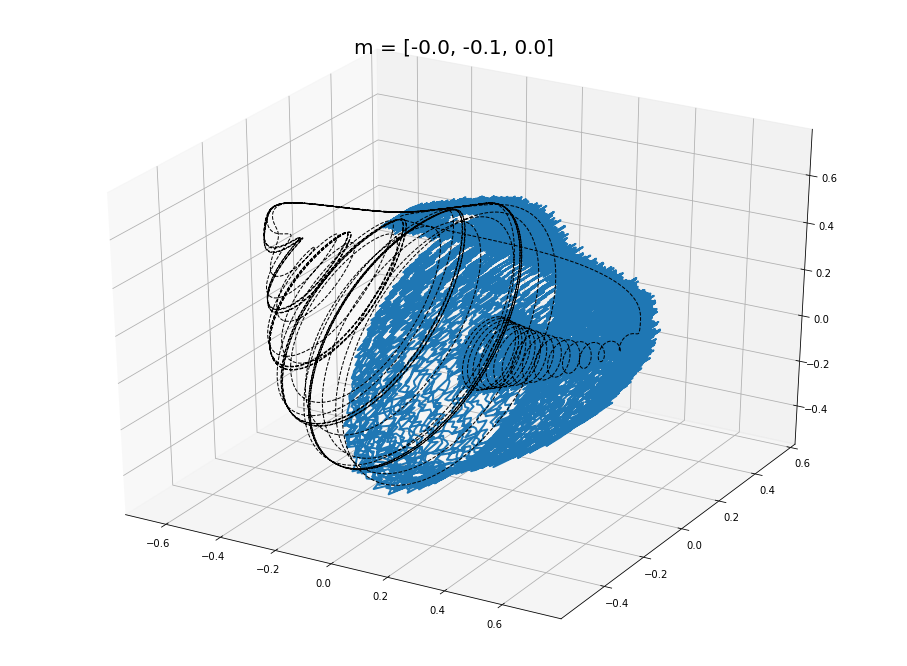

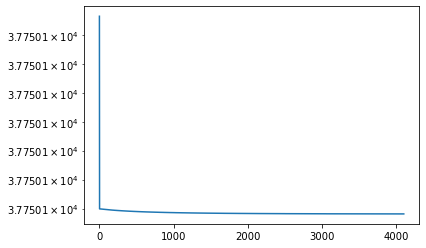

In [4]:
# Plot the results
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'},figsize=(16,12))
ax.plot(x_t[:,0], x_t[:,1], x_t[:,2],linewidth=2)
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['h0'] = 1e-5
x_pred = model.simulate(x0_train, t, integrator_kws=integrator_keywords)
if np.all(eigvals < 0.0):
    ax.plot(x_pred[:tmax,0], x_pred[:tmax,1], x_pred[:tmax,2], 'k--', linewidth=1)
    ax.set_title('m = [{0:.1f}, '.format(opt_m[0]) + '{0:.1f}, '.format(opt_m[1]) + '{0:0.1f}]'.format(opt_m[2]), fontsize=20)
else:
    ax.plot(x_pred[:tmax,0], x_pred[:tmax,1], x_pred[:tmax,2], 'g--', linewidth=2)

plt.figure(200)
plt.semilogy(sindy_opt.objective_history[1:])

In [5]:
# Check energy-preserving constraint is satisfied (Qijk + Qjik + Qkij = 0)
# and Cw = d

Ls = np.tensordot(PL_tensor, Xi, axes=([3,2],[0,1]))
Q = np.tensordot(PQ_tensor, Xi, axes=([2],[0]))
Qsum = np.sum(Q + np.transpose(Q, [0, 2, 1]) + np.transpose(Q, [2, 1, 0]))
print(Q + np.transpose(Q, [0, 2, 1]) + np.transpose(Q, [2, 1, 0]))
print(np.dot(constraint_matrix, Xi.flatten()))

[[[ 3.20002886e-16  1.55431223e-15 -2.22044605e-16]
  [ 1.55431223e-15  7.77156117e-16 -8.32667268e-16]
  [-2.22044605e-16 -8.32667268e-16 -1.33226763e-15]]

 [[ 1.55431223e-15  7.77156117e-16 -8.32667268e-16]
  [ 7.77156117e-16  2.80654682e-16 -4.44089210e-16]
  [-8.32667268e-16 -4.44089210e-16 -5.32907052e-15]]

 [[-2.22044605e-16 -8.32667268e-16 -1.33226763e-15]
  [-8.32667268e-16 -4.44089210e-16 -5.32907052e-15]
  [-1.33226763e-15 -5.32907052e-15 -5.15995601e-16]]]
[ 1.06667629e-16  9.35515606e-17 -1.71998534e-16  7.77156117e-16
 -1.33226763e-15 -5.32907052e-15  1.55431223e-15 -2.22044605e-16
 -4.44089210e-16 -1.66533454e-15]


In [6]:
# Repeat with accelerated prox-gradient descent
# Define the hyperparams and perform the optimization (regular prox-gradient)
eta = 1.0e2
gamma = 1.0/eta
beta = 0.5
threshold = 0.0
sindy_opt = ps.clSR3(threshold=threshold, eta=eta, gamma=gamma, beta=beta, vtol=1e-5, accel=True,
                            PL=PL_tensor, PQ=PQ_tensor, max_iter=40000, tol=1e-10,
                            thresholder="l1", eigmin=-1e50, eigmax=-0.01,
                            constraint_lhs=constraint_matrix,
                            constraint_rhs=constraint_zeros,
                            constraint_order="feature")

model = ps.SINDy(
            optimizer=sindy_opt,
            feature_library=sindy_library,
            differentiation_method=ps.FiniteDifference(drop_endpoints=True),
        )
model.fit(x_t, t=t)
Xi = model.coefficients().T

# Use optimal m, and calculate eigenvalues(PW) to see if identified model is stable
opt_m = sindy_opt.m_history_[-1]
mPQ = np.zeros(PL_tensor.shape)
for i in range(r):
    for j in range(i+1, r):
        mPQ[i, j, :, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = opt_m
for i in range(r):
    mPQ[i, i, :, Nr - r + i] = opt_m
for i in range(r):
    for j in range(Nr):
        mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)     
P_tensor = PL_tensor - mPQ
As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
eigvals, eigvecs = np.linalg.eig(As)
print('proxgrad, As eigvals: ', eigvals)
print(opt_m)
smallest_eigval = np.sort(eigvals)[0]
largest_eigval = np.sort(eigvals)[-1]
L = np.tensordot(PL_tensor, Xi, axes=([3,2],[0,1]))
Q = np.tensordot(PQ_tensor, Xi, axes=([2],[0]))
d = np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([2],[0])), opt_m)
Rm = np.sqrt(smallest_eigval/largest_eigval)*np.linalg.norm(d)
print(d, Rm)

model.print()
print(np.dot(constraint_matrix, (sindy_opt.history_[0]).T.flatten()))
print(np.dot(constraint_matrix, (sindy_opt.history_[1]).T.flatten()))

75498.99168074943 5.077305684683328e-05 0.0
[-0.04133387  0.06715251 -0.20486193] 0
75500.22524878099 0.008956968833614682 0.0
[-0.04121476  0.03518216 -0.17211772] 1
75500.22524878099 0.005289603412699192 0.0
[-0.0410352   0.0077291  -0.13976581] 2
75500.22524878099 0.0028221003610114826 0.0
[-0.04078129 -0.01349952 -0.11034059] 3
75500.22524878099 0.0013867077771478704 0.0
[-0.04043722 -0.02835494 -0.08530053] 4
75500.22524878099 0.0006470808137293854 0.0
[-0.0399878  -0.03787692 -0.06513673] 5
75500.22524878099 0.0002996541367335659 0.0
[-0.03942394 -0.04356449 -0.04954845] 6
75500.22524878099 0.00014509557352833247 0.0
[-0.03874572 -0.04677942 -0.03778214] 7
75500.22524878099 7.670232175142211e-05 0.0
[-0.03798134 -0.04857098 -0.02896419] 8
75500.22524878099 4.509194058400403e-05 0.0
[-0.03715759 -0.04954952 -0.0223324 ] 9
75500.22524878099 2.9496419015151034e-05 0.0
[-0.03629592 -0.05008191 -0.01728964] 10
75500.22524878099 2.1143227759221582e-05 0.0
[-0.03541113 -0.05037299 -0.01

[ 0.01270672 -0.05440559  0.01074911] 137
75500.22524878099 1.177235354328307e-09 0.0
[ 0.01270829 -0.05440518  0.01075631] 138
75500.22524878099 1.1628607720715473e-09 0.0
75500.22524878099 1.1628607720715473e-09 0.0
[ 0.00638909 -0.03496227  0.00752701] 0
75500.22524556826 2.128558882808379e-05 0.0
[ 0.00640755 -0.0330246   0.00681227] 1
75500.22524556826 5.176456723710035e-06 0.0
[ 0.00642585 -0.03345367  0.00688959] 2
75500.22524556826 4.034796914911748e-06 0.0
[ 0.00644853 -0.033547    0.00682106] 3
75500.22524556826 3.7444159502138167e-06 0.0
[ 0.00647446 -0.03382915  0.0068077 ] 4
75500.22524556826 3.630885123538839e-06 0.0
[ 0.00650393 -0.03410108  0.00677715] 5
75500.22524556826 3.500468720194188e-06 0.0
[ 0.00653675 -0.03441114  0.00674955] 6
75500.22524556826 3.36994624184111e-06 0.0
[ 0.00657286 -0.03473526  0.00671712] 7
75500.22524556826 3.2325440236537922e-06 0.0
[ 0.00661214 -0.03507611  0.00668213] 8
75500.22524556826 3.092477152419547e-06 0.0
[ 0.00665451 -0.0354286  

75500.22524556826 1.2331113889243217e-08 0.0
[ 0.0088071  -0.0497855   0.00669948] 103
75500.22524556826 1.1848653513839315e-08 0.0
[ 0.00880411 -0.04979868  0.00672915] 104
75500.22524556826 1.1385516699030827e-08 0.0
[ 0.00880201 -0.04981141  0.00675838] 105
75500.22524556826 1.0940729231523032e-08 0.0
[ 0.00880077 -0.04982372  0.00678715] 106
75500.22524556826 1.0513401620399679e-08 0.0
[ 0.00880036 -0.04983562  0.00681546] 107
75500.22524556826 1.0102723210117948e-08 0.0
[ 0.00880075 -0.04984714  0.00684334] 108
75500.22524556826 9.707956014464306e-09 0.0
[ 0.0088019  -0.04985828  0.00687076] 109
75500.22524556826 9.32842835123536e-09 0.0
[ 0.00880378 -0.04986906  0.00689774] 110
75500.22524556826 8.963528363022026e-09 0.0
[ 0.00880634 -0.04987951  0.00692428] 111
75500.22524556826 8.61269751215054e-09 0.0
[ 0.00880954 -0.04988963  0.00695038] 112
75500.22524556826 8.27542413799947e-09 0.0
[ 0.00881334 -0.04989943  0.00697605] 113
75500.22524556826 7.951237162611748e-09 0.0
[ 0.008

75500.22524562641 6.276176287377529e-07 0.0
[ 0.00820758 -0.04385466  0.0037127 ] 37
75500.22524562641 5.824981855383997e-07 0.0
[ 0.00831532 -0.04411157  0.00370544] 38
75500.22524562641 5.409170904528374e-07 0.0
[ 0.00841938 -0.04435888  0.00370221] 39
75500.22524562641 5.02621956368337e-07 0.0
[ 0.00851956 -0.04459677  0.00370292] 40
75500.22524562641 4.673713048923763e-07 0.0
[ 0.00861568 -0.04482544  0.00370748] 41
75500.22524562641 4.349352250043552e-07 0.0
[ 0.0087076  -0.04504512  0.00371577] 42
75500.22524562641 4.0509580912227517e-07 0.0
[ 0.00879515 -0.04525603  0.00372768] 43
75500.22524562641 3.7764739603474034e-07 0.0
[ 0.00887823 -0.04545841  0.00374307] 44
75500.22524562641 3.5239664802338417e-07 0.0
[ 0.00895672 -0.04565252  0.00376179] 45
75500.22524562641 3.2916248731463736e-07 0.0
[ 0.00903055 -0.04583859  0.00378369] 46
75500.22524562641 3.0777591478876705e-07 0.0
[ 0.00909965 -0.04601689  0.00380862] 47
75500.22524562641 2.8807973167318224e-07 0.0
[ 0.00916397 -0.

[ 0.00902709 -0.05007346  0.00750117] 147
75500.22524562641 3.0496375094243184e-09 0.0
[ 0.00902509 -0.05007822  0.00751711] 148
75500.22524562641 2.939061299338957e-09 0.0
[ 0.0090224  -0.05008286  0.00753276] 149
75500.22524562641 2.831664519341687e-09 0.0
[ 0.00901904 -0.05008738  0.00754812] 150
75500.22524562641 2.7273716456862605e-09 0.0
[ 0.00901506 -0.0500918   0.00756321] 151
75500.22524562641 2.6261323062148485e-09 0.0
[ 0.00901049 -0.05009611  0.00757801] 152
75500.22524562641 2.5279172273829386e-09 0.0
[ 0.00900536 -0.05010031  0.00759255] 153
75500.22524562641 2.4327140776352006e-09 0.0
[ 0.00899973 -0.05010441  0.00760683] 154
75500.22524562641 2.340523299646238e-09 0.0
[ 0.00899363 -0.05010842  0.00762084] 155
75500.22524562641 2.2513540198591305e-09 0.0
[ 0.00898711 -0.05011233  0.00763461] 156
75500.22524562641 2.1652201179461534e-09 0.0
[ 0.00898022 -0.05011615  0.00764813] 157
75500.22524562641 2.0821365313621056e-09 0.0
[ 0.008973   -0.05011988  0.00766141] 158
7550

75500.2252456248 2.0831369566263658e-07 0.0
[ 0.00940863 -0.04694832  0.00404199] 53
75500.2252456248 1.961507568059597e-07 0.0
[ 0.00944423 -0.04707925  0.00408255] 54
75500.2252456248 1.8487021117889567e-07 0.0
[ 0.00947524 -0.04720443  0.00412488] 55
75500.2252456248 1.7439270371932013e-07 0.0
[ 0.00950177 -0.04732408  0.00416882] 56
75500.2252456248 1.6464625846509307e-07 0.0
[ 0.00952389 -0.04743845  0.00421423] 57
75500.2252456248 1.5556574714594387e-07 0.0
[ 0.00954174 -0.04754775  0.00426097] 58
75500.2252456248 1.4709237136350962e-07 0.0
[ 0.00955544 -0.0476522   0.00430888] 59
75500.2252456248 1.3917316133711768e-07 0.0
[ 0.00956513 -0.04775203  0.00435784] 60
75500.2252456248 1.3176049355301235e-07 0.0
[ 0.00957096 -0.04784743  0.00440772] 61
75500.2252456248 1.2481162911200277e-07 0.0
[ 0.00957309 -0.0479386   0.00445841] 62
75500.2252456248 1.1828827411264787e-07 0.0
[ 0.00957169 -0.04802574  0.00450977] 63
75500.2252456248 1.1215616302329724e-07 0.0
[ 0.00956693 -0.048109

75500.2252456248 1.7019588756842139e-09 0.0
[ 0.00893372 -0.05013782  0.00772645] 163
75500.2252456248 1.6376020718637344e-09 0.0
[ 0.00892563 -0.05014105  0.00773835] 164
75500.2252456248 1.57616848366981e-09 0.0
[ 0.00891756 -0.0501442   0.00775005] 165
75500.2252456248 1.5175947692527584e-09 0.0
[ 0.00890955 -0.05014728  0.00776155] 166
75500.2252456248 1.4618036055711797e-09 0.0
[ 0.00890164 -0.05015029  0.00777284] 167
75500.2252456248 1.408704208719062e-09 0.0
[ 0.00889388 -0.05015323  0.00778395] 168
75500.2252456248 1.3581932295548668e-09 0.0
[ 0.00888631 -0.05015611  0.00779487] 169
75500.2252456248 1.3101559818327992e-09 0.0
[ 0.00887896 -0.05015892  0.0078056 ] 170
75500.2252456248 1.2644679546316322e-09 0.0
[ 0.00887187 -0.05016167  0.00781614] 171
75500.2252456248 1.2209965567694753e-09 0.0
[ 0.00886509 -0.05016436  0.00782651] 172
75500.2252456248 1.179603038260155e-09 0.0
[ 0.00885863 -0.05016699  0.00783671] 173
75500.2252456248 1.1401445324832225e-09 0.0
[ 0.00885252 -

75500.22524562481 8.639394546292145e-08 0.0
[ 0.00949952 -0.0484738   0.00482663] 69
75500.22524562481 8.20691132840555e-08 0.0
[ 0.00947871 -0.0485375   0.00488   ] 70
75500.22524562481 7.79784552530031e-08 0.0
[ 0.00945593 -0.04859846  0.00493334] 71
75500.22524562481 7.41077947835896e-08 0.0
[ 0.0094314  -0.0486568   0.00498658] 72
75500.22524562481 7.04443002851831e-08 0.0
[ 0.00940532 -0.04871266  0.00503966] 73
75500.22524562481 6.69762996595953e-08 0.0
[ 0.0093779  -0.04876614  0.00509252] 74
75500.22524562481 6.36931148684234e-08 0.0
[ 0.00934934 -0.04881738  0.00514511] 75
75500.22524562481 6.058491563868658e-08 0.0
[ 0.00931985 -0.04886647  0.00519739] 76
75500.22524562481 5.7642591310323796e-08 0.0
[ 0.00928961 -0.04891352  0.00524931] 77
75500.22524562481 5.485763977211453e-08 0.0
[ 0.00925883 -0.04895863  0.00530083] 78
75500.22524562481 5.222207238417671e-08 0.0
[ 0.0092277  -0.04900189  0.00535193] 79
75500.22524562481 4.972833374494488e-08 0.0
[ 0.00919638 -0.04904338  

[ 0.00883216 -0.05017931  0.00788518] 178
75500.22524562481 9.668149026364722e-10 0.0
[ 0.00882818 -0.05018161  0.00789439] 179
75500.22524562481 9.359997507378722e-10 0.0
[ 0.00882467 -0.05018387  0.00790345] 180
75500.22524562481 9.061760841599755e-10 0.0
[ 0.00882164 -0.05018608  0.00791236] 181
75500.22524562481 8.772386344808049e-10 0.0
[ 0.00881909 -0.05018824  0.00792111] 182
75500.22524562481 8.490934599045725e-10 0.0
[ 0.00881703 -0.05019035  0.00792972] 183
75500.22524562481 8.216586458089376e-10 0.0
[ 0.00881545 -0.05019242  0.00793819] 184
75500.22524562481 7.948647306264192e-10 0.0
[ 0.00881436 -0.05019445  0.00794651] 185
75500.22524562481 7.68654857636075e-10 0.0
[ 0.00881375 -0.05019643  0.00795469] 186
75500.22524562481 7.429846596787076e-10 0.0
[ 0.0088136  -0.05019837  0.00796274] 187
75500.22524562481 7.178218897611175e-10 0.0
[ 0.00881391 -0.05020027  0.00797065] 188
75500.22524562481 6.931458159179858e-10 0.0
[ 0.00881466 -0.05020213  0.00797842] 189
75500.2252456

[ 0.00907278 -0.04919339  0.0056    ] 84
75500.22524562478 3.914556153059181e-08 0.0
[ 0.00904307 -0.04922726  0.00564797] 85
75500.22524562478 3.7361478333382275e-08 0.0
[ 0.00901412 -0.04925982  0.00569536] 86
75500.22524562478 3.5674296143541844e-08 0.0
[ 0.00898605 -0.04929113  0.00574214] 87
75500.22524562478 3.407842628942886e-08 0.0
[ 0.00895899 -0.04932124  0.00578832] 88
75500.22524562478 3.256846346736916e-08 0.0
[ 0.00893304 -0.04935021  0.00583388] 89
75500.22524562478 3.1139189349001936e-08 0.0
[ 0.0089083  -0.04937809  0.00587881] 90
75500.22524562478 2.9785578661307273e-08 0.0
[ 0.00888484 -0.04940493  0.0059231 ] 91
75500.22524562478 2.8502806886294203e-08 0.0
[ 0.00886276 -0.04943079  0.00596677] 92
75500.22524562478 2.7286258806943764e-08 0.0
[ 0.00884211 -0.04945569  0.00600979] 93
75500.22524562478 2.613153720968367e-08 0.0
[ 0.00882295 -0.0494797   0.00605217] 94
75500.22524562478 2.503447114059661e-08 0.0
[ 0.00880533 -0.04950284  0.0060939 ] 95
75500.22524562478 

75500.22524562478 5.992459717904734e-10 0.0
[ 0.00882176 -0.0502092   0.00800823] 193
75500.22524562478 5.770286617722749e-10 0.0
[ 0.00882444 -0.05021088  0.00801536] 194
75500.22524562478 5.553584427834483e-10 0.0
[ 0.00882745 -0.05021252  0.00802237] 195
75500.22524562478 5.342641276348944e-10 0.0
[ 0.00883075 -0.05021413  0.00802926] 196
75500.22524562478 5.137761195552905e-10 0.0
[ 0.00883431 -0.05021571  0.00803603] 197
75500.22524562478 4.939250303823898e-10 0.0
[ 0.0088381  -0.05021725  0.00804269] 198
75500.22524562478 4.747403745275801e-10 0.0
[ 0.0088421  -0.05021877  0.00804922] 199
75500.22524562478 4.562493652093533e-10 0.0
[ 0.00884628 -0.05022025  0.00805564] 200
75500.22524562478 4.384758359974625e-10 0.0
[ 0.0088506  -0.05022171  0.00806195] 201
75500.22524562478 4.2143930684741774e-10 0.0
[ 0.00885504 -0.05022313  0.00806815] 202
75500.22524562478 4.051542096738959e-10 0.0
[ 0.00885956 -0.05022453  0.00807424] 203
75500.22524562478 3.8962928420956626e-10 0.0
[ 0.0088

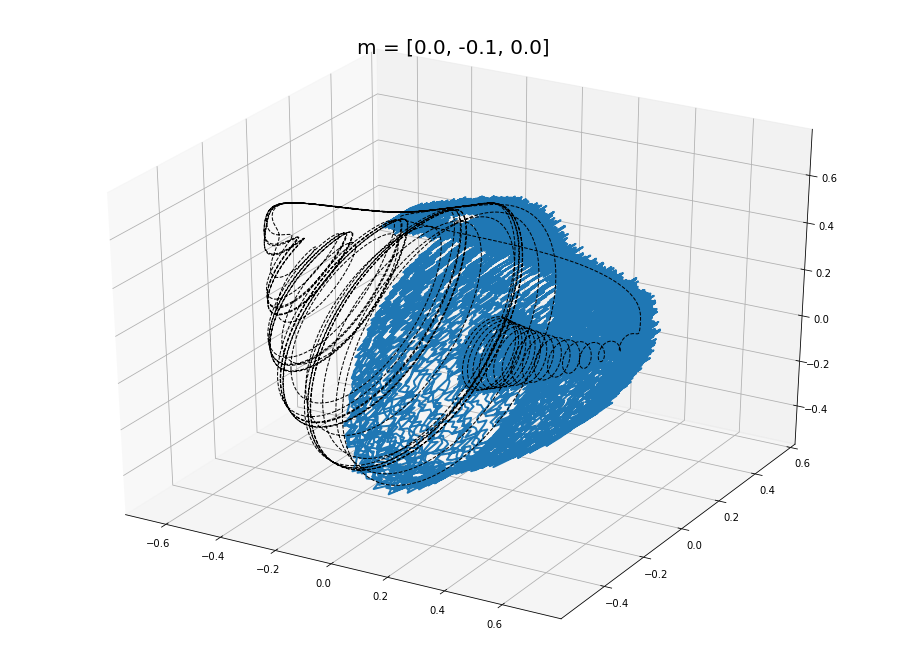

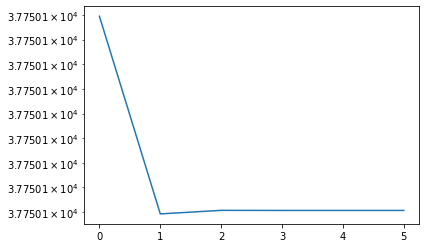

In [7]:
# Plot the results
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'},figsize=(16,12))
ax.plot(x_t[:,0], x_t[:,1], x_t[:,2],linewidth=2)
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['h0'] = 1e-5
x_pred = model.simulate(x0_train, t, integrator_kws=integrator_keywords)
if np.all(eigvals < 0.0):
    ax.plot(x_pred[:tmax,0], x_pred[:tmax,1], x_pred[:tmax,2], 'k--', linewidth=1)
    ax.set_title('m = [{0:.1f}, '.format(opt_m[0]) + '{0:.1f}, '.format(opt_m[1]) + '{0:0.1f}]'.format(opt_m[2]), fontsize=20)
else:
    ax.plot(x_pred[:tmax,0], x_pred[:tmax,1], x_pred[:tmax,2], 'g--', linewidth=2)

plt.figure(200)
plt.semilogy(sindy_opt.objective_history[1:])

### Note accelerated prox-gradient only took 5 steps instead of ~4000!!